In [2]:
# Mounting Gdrive on colab
from google.colab import drive
drive.mount('/content/gdrive')


# **Credit Card Fraud Detection**







**Problem Statement:**

Finex is a leading financial service provider based out of Florida, US. It offers a wide range of products and business services to customers through different channels, ranging from in-person banking and ATMs to online banking. Over the last few years, Finex has observed that a significantly large number of unauthorised transactions are being made, due to which the bank has been facing a huge revenue and profitability crisis. Many customers have been complaining about unauthorised transactions being made through their credit/debit cards. It has been reported that fraudsters use stolen/lost cards and hack private systems to access the personal and sensitive data of many cardholders. They also indulge in ATM skimming at various POS terminals such as gas stations, shopping malls, and ATMs that do not send alerts or do not have OTP systems through banks. Such fraudulent activities have been reported to happen during non-peak and odd hours of the day leaving no room for suspicion.

In most cases, customers get to know of such unauthorised transactions happening through their cards quite late as they are unaware of such ongoing credit card frauds or they do not monitor their bank account activities closely. This has led to late complaint registration with Finex and by the time the case is flagged fraudulent, the bank incurs heavy losses and ends up paying the lost amount to the cardholders.

Now, Finex is also not really equipped with the latest financial technologies, and it is becoming difficult for the bank to track these data breaches on time to prevent further losses. The Branch Manager is worried about the ongoing situation and wants to identify the possible root causes and action areas to come up with a long-term solution that would help the bank generate high revenue with minimal losses.

**Goal:**

Develop a machine learning model to detect fraudulent transactions based on the historical transactional data of customers with a pool of merchants.Based on your understanding of the model, you have to analyse the business impact of these fraudulent transactions and recommend the optimal ways that the bank can adopt to mitigate the fraud risks.


# Importing Libraries & datasets

In [3]:
#Importing all required libraries

#Basic libraries
import warnings
warnings.filterwarnings('ignore')

import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set_theme();
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px

#Libraries for Linear Classification model
from sklearn.model_selection import  train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, roc_curve, recall_score, precision_score, roc_auc_score, plot_roc_curve, classification_report
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics


#Libraries for Decision Trees & Random forests
from IPython.display import Image
from six import StringIO
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
import graphviz
from sklearn.ensemble import RandomForestClassifier

# Libaries for sampling
from imblearn.over_sampling import ADASYN

In [4]:
#Importing datasets
df1 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Capstone Project/fraudTest.csv')
df2 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Capstone Project/fraudTrain.csv')

#Checking the shape of the two data frames
print('DF1 shape: ', df1.shape)
print('DF2 shape: ', df2.shape)

DF1 shape:  (555719, 23)
DF2 shape:  (1296675, 23)


In [5]:
#Merging the two dataframes into one
master_df = df1.append(df2)

#Checking the shape after merging
print('Master dataframe shape": ', master_df.shape)

Master dataframe shape":  (1852394, 23)


# Data Understanding

## Checking the basics

In [6]:
#Checking first few rows of the dataframe
master_df.head(5)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


**Observations:**

> There are few unwanted columns. We'll drop them going ahead.

In [7]:
# Checking for the info
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

**Observation:** 

> Data type for all columns are of correct data types

In [8]:
# Checking detailed description
master_df.describe().apply(lambda x:x.apply('{0:.2f}'.format))


,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00
mean,537193.44,417386038394021696.00,70.06,48813.26,38.54,-90.23,88643.67,1358674218.83,38.54,-90.23,0.01
std,366910.96,1309115265318056448.00,159.25,26881.85,5.07,13.75,301487.62,18195081.39,5.11,13.76,0.07
min,0.00,60416207185.00,1.00,1257.00,20.03,-165.67,23.00,1325376018.00,19.03,-166.67,0.00
25%,231549.00,180042946491150.00,9.64,26237.00,34.67,-96.80,741.00,1343016823.75,34.74,-96.90,0.00
50%,463098.00,3521417320836166.00,47.45,48174.00,39.35,-87.48,2443.00,1357089331.00,39.37,-87.44,0.00
75%,833575.75,4642255475285942.00,83.10,72042.00,41.94,-80.16,20328.00,1374581485.25,41.96,-80.25,0.00
max,1296674.00,4992346398065154048.00,28948.90,99921.00,66.69,-67.95,2906700.00,1388534374.00,67.51,-66.95,1.00


**Observation:** 

> Out of 23 columns, 11 colummns are numeric.

> Unnamed is just another column as the index.

> Amt, city pop columns have outliers, which will be treated during univariate analysis.

> Let's split trans_date_trans_time	intow two different columns


## Transistioning columns

In [9]:
# Splitting trans_date_trans_time to two different columns

# new data frame with split value columns 
split_df = master_df["trans_date_trans_time"].str.split(" ", n = 1, expand = True) 

# making separate transaction date column 
master_df["Trans_date"]= split_df[0] 
  
# making separate transaction time column 
master_df["Trans_time"]= split_df[1] 

# Deleting split_df to release memory
del split_df

In [10]:
# Function to convert the time into seconds format
def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

# Applying the above function to dataframe column
master_df['Trans_time(secs)'] = master_df['Trans_time'].apply(get_sec)
master_df.head(3)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,Trans_date,Trans_time,Trans_time(secs)
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,2020-06-21,12:14:25,44065
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,2020-06-21,12:14:33,44073
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,2020-06-21,12:14:53,44093


In [11]:
# Converting seconds to categorical column
master_df['Time_of_day'] = master_df['Trans_time(secs)'].apply(lambda x: 'Early_morning' if x <= 21600 else 'Morning' if ((x > 21600) and (x <= 43200))
                                                                 else 'Afternoon' if ((x > 43200) and (x <= 64800)) else 'Evening')


In [12]:
# Adding a new column - Day

master_df['Trans_date'] = pd.to_datetime(master_df['Trans_date'], format='%Y-%m-%d')
master_df['Week_day'] = (master_df['Trans_date'].dt.dayofweek) + 1

# Converting week_day to object type
master_df['Week_day'] = master_df['Week_day'].astype(np.object)
master_df.head(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,Trans_date,Trans_time,Trans_time(secs),Time_of_day,Week_day
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,2020-06-21,12:14:25,44065,Afternoon,7



## Dropping unnecessary columns

In [13]:
# Deleting columns which wont be required for further analysis
master_df.drop(master_df.columns[0], axis = 1, inplace=True)
master_df.drop(['trans_date_trans_time','first','last','zip','trans_num','unix_time','dob','Trans_time','Trans_date','street','city','merchant','job','Trans_time(secs)'],axis=1,inplace=True)
master_df.shape

(1852394, 13)

**Justifications for deleting columns:**

**trans_date_trans_time**

> New columns have been created by splitting this column. Hence deleting it

**first name , last name , dob, job,trans_num**

> These columns are not required for building the models.

**unix_time**

>There is already a sepearte column with time converted into secs. Information is being repeated. Hence deleting

**Street,city, zip**

> This information is till been given by lattitudes & Longitudes

**Merchant**

> This column holds the merchant names & wont be useful for model building. 

## Drop Duplicates

In [14]:
# Checking if any duplicate rows exist in data set
master_df.drop_duplicates(inplace = True)
master_df.shape

(1852394, 13)

**Observations:**

> Since the shape of the dataframe remains the same after and before dropping duplicates. Its confirmed that there are no duplicate rows.

## Data Checks


In [15]:
# Making another column to check the length of credit card
master_df['cc_len'] = master_df['cc_num'].astype(str).map(len)

In [16]:
# Checking min & max length of credit cards
print ('Min length of cc_num:', master_df['cc_len'].min())
print ('Max length of cc_num:', master_df['cc_len'].max())

Min length of cc_num: 11
Max length of cc_num: 19


**Observations:**

> Credit cards do have a range between 10 - 19. (Google as the reference)

> Since the length of all cards fall in between 11 - 19, all transactions are said to be valid

>Hence, there is no need to drop any rows.

In [17]:
#Deleting this extra column
master_df.drop('cc_len', axis = 1, inplace = True)

# Chaning the type of cc_num back to int64
master_df['cc_num'] = master_df['cc_num'].astype(int)

master_df.head(1)

,cc_num,category,amt,gender,state,lat,long,city_pop,merch_lat,merch_long,is_fraud,Time_of_day,Week_day
0,2291163933867244,personal_care,2.86,M,SC,33.9659,-80.9355,333497,33.986391,-81.200714,0,Afternoon,7


## Checking missing value counts

In [18]:
# Checking for null values present in the columns
(master_df.isnull().sum()/len(master_df))*100

cc_num         0.0
category       0.0
amt            0.0
gender         0.0
state          0.0
lat            0.0
long           0.0
city_pop       0.0
merch_lat      0.0
merch_long     0.0
is_fraud       0.0
Time_of_day    0.0
Week_day       0.0
dtype: float64

**Observation:** 

>There are no nulls present in any of the columns

## Checking Imbalance ratio

In [19]:
#Checking Imbalance count
(master_df['is_fraud'].value_counts(normalize=True))*100

0    99.478999
1     0.521001
Name: is_fraud, dtype: float64

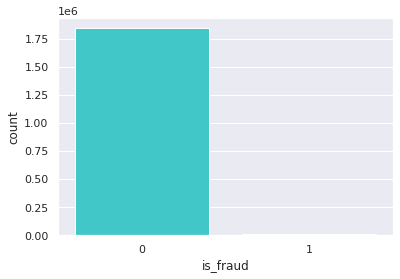

In [20]:
#Plotting imbalance counts
sns.countplot(x = 'is_fraud', data = master_df, palette='rainbow')
plt.show()

**Observation:** 

>The data is heavily imabalnced. 

>Going ahead, will handle data imbalance by using ADASYN technique and class_weight technique while building the models


## Vislualizations

### Univariate - Numerical

In [21]:
# Defining numerical columns
numvars = ['amt',  'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']

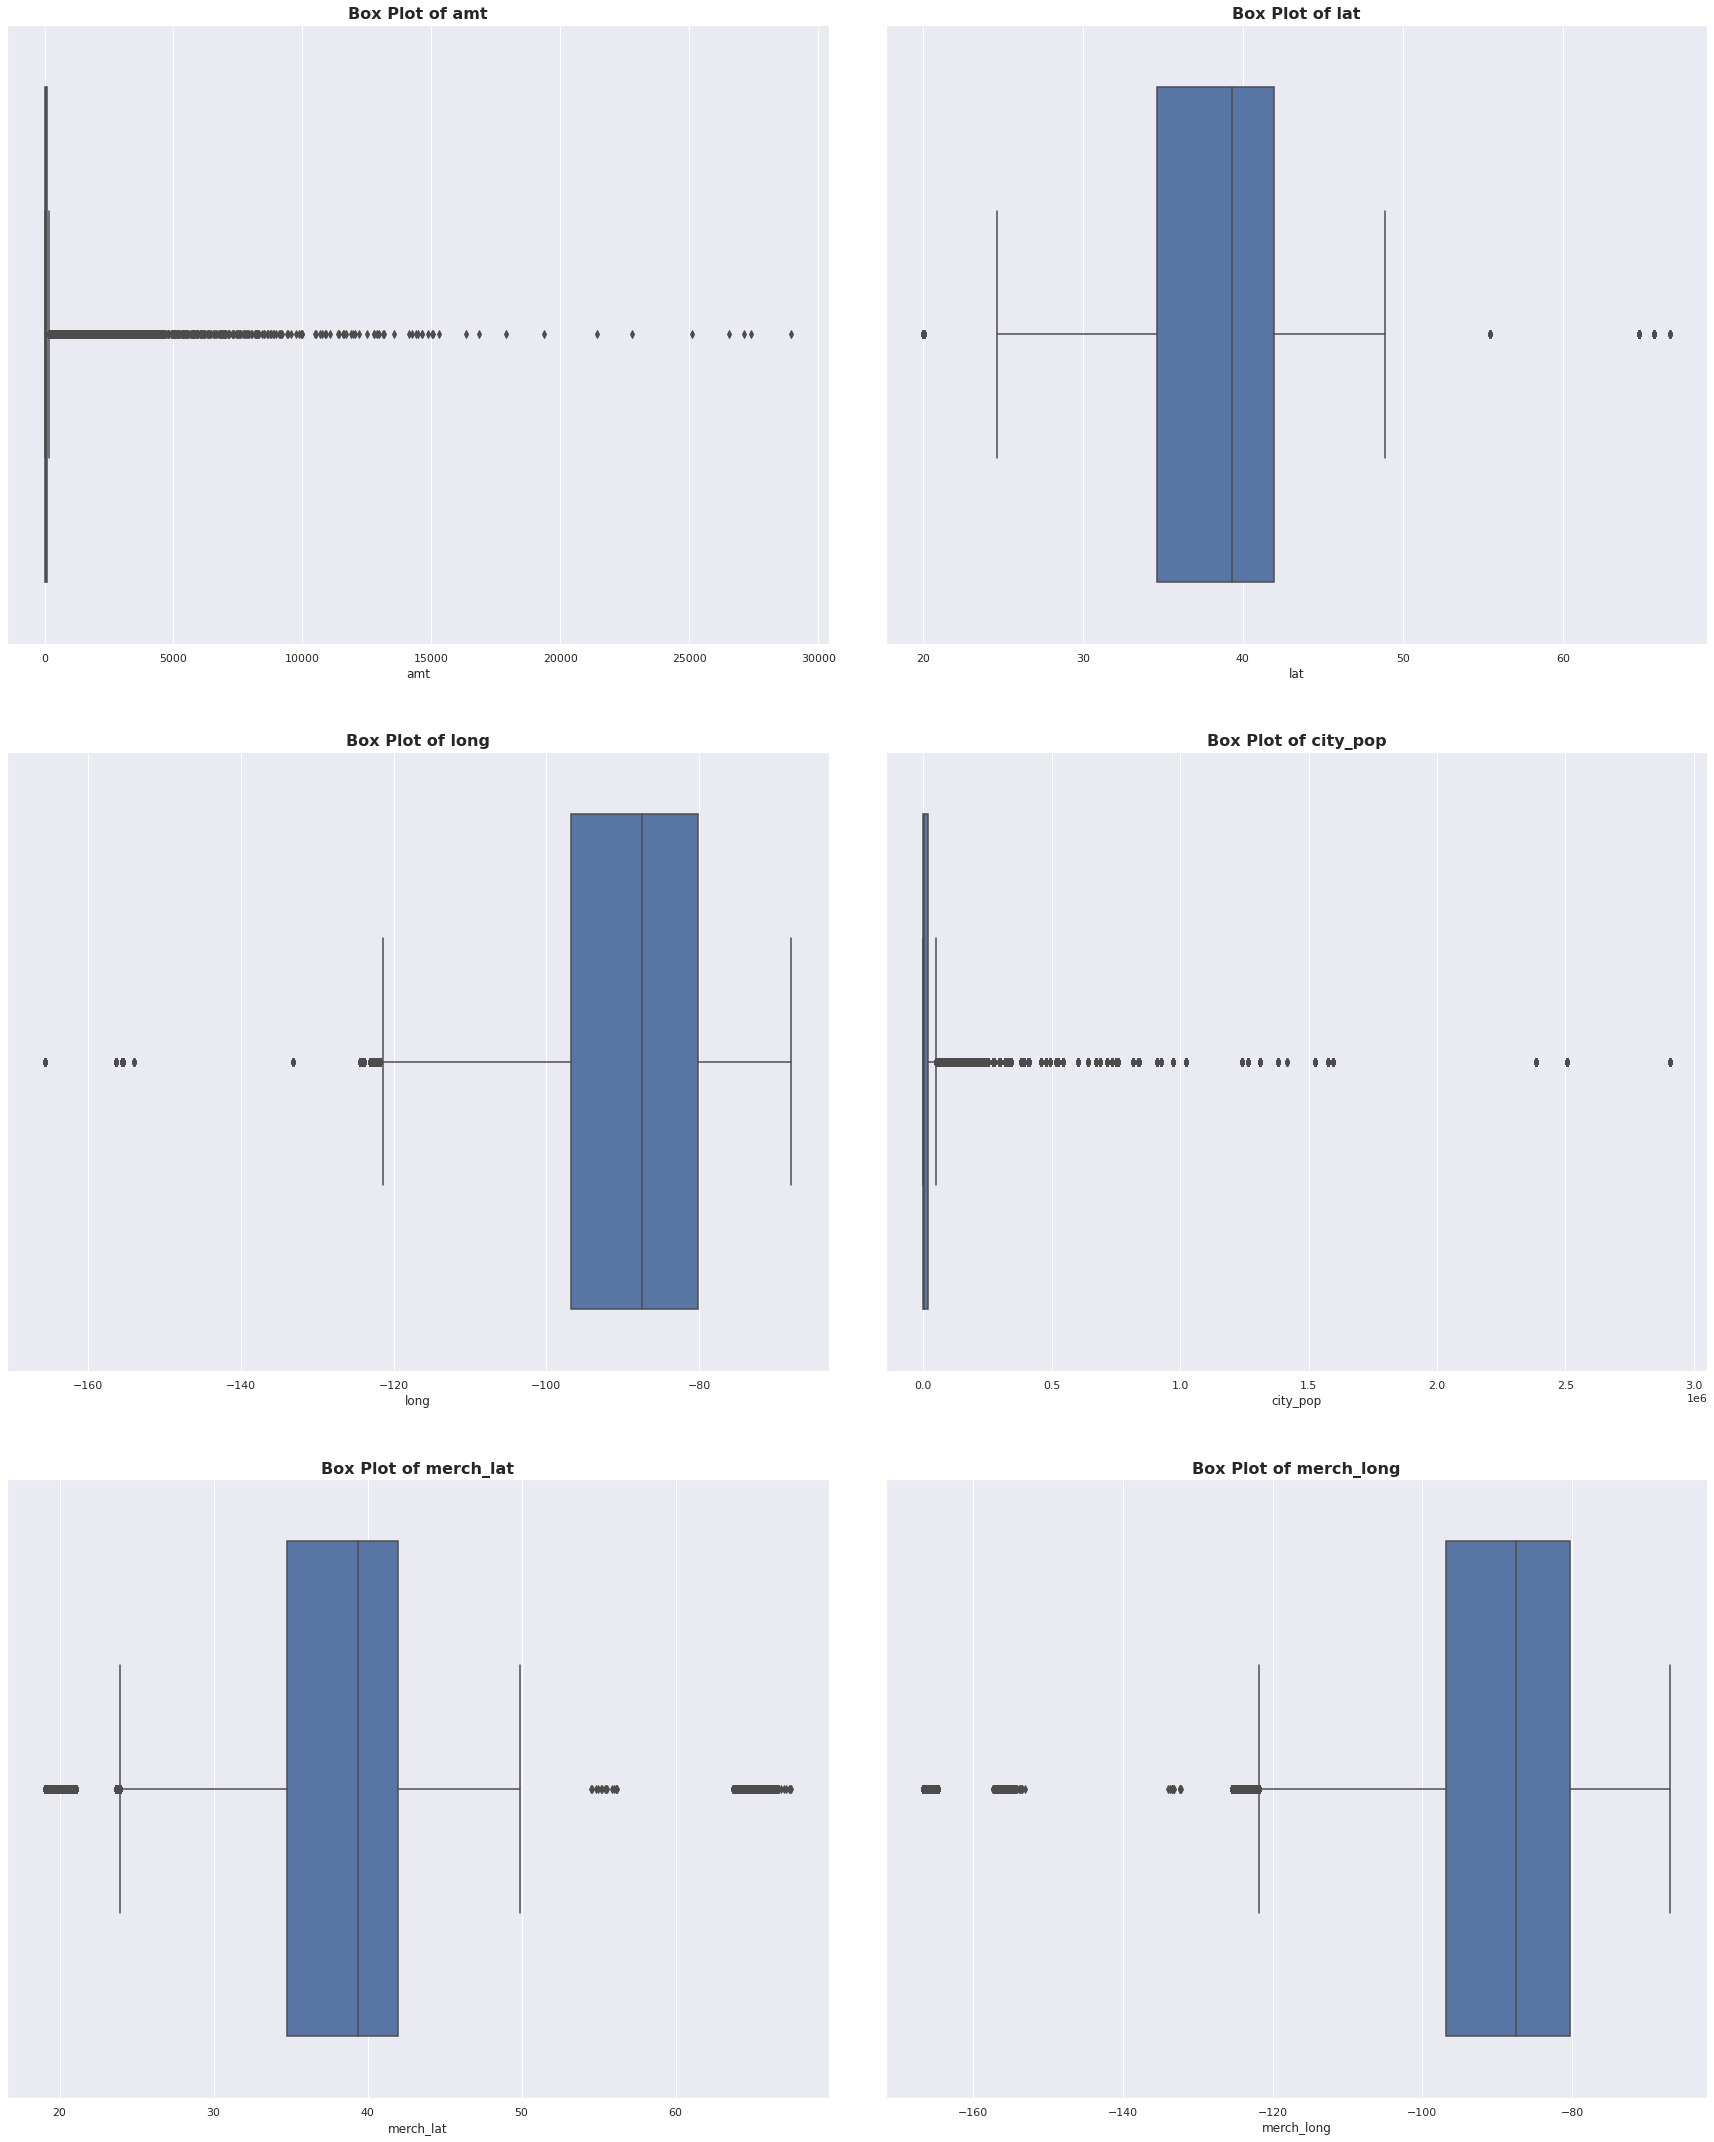

In [22]:
# Box plots
plt.figure(figsize = (25,30))
for var in enumerate(numvars):
    plt.subplot(3,2,var[0]+1)
    plt.title("Box Plot of " + var[1], fontweight = 'bold', fontsize = 16)
    sns.boxplot(master_df[var[1]])
    
    plt.tight_layout(pad=5.0)
    plt.subplots_adjust(top=1.0)

**Observations:** 

>There are outliers in amount and city population. 

>Since we are going to make models its necessary to handle outliers.

>Lets go ahead and deep dive into various quartiles for outlier handling purpose

#### Treating Outliers

##### Amount column

In [23]:
#Checking variours percentile ranges
master_df['amt'].quantile([0.25,0.50,0.75,0.90,0.95,0.97,0.98,0.99,0.999,1])

0.250        9.64000
0.500       47.45000
0.750       83.10000
0.900      136.33000
0.950      195.34000
0.970      245.15000
0.980      332.71000
0.990      537.90000
0.999     1517.24105
1.000    28948.90000
Name: amt, dtype: float64

In [24]:
# Defining 1st quartile, 3rd quartile, lower & upper bounds
q1 = master_df['amt'].quantile(0.25)
q3 = master_df['amt'].quantile(0.999)
iqr = q3 - q1
lower_bound = q1 - (1.5*iqr)
upper_bound = q3 + (1.5*iqr)
print('Q1: ',q1)
print('Q3: ',q3)
print('Lower bound: ',lower_bound)
print('Upper Bound:', upper_bound)

Q1:  9.64
Q3:  1517.2410500000465
Lower bound:  -2251.7615750000696
Upper Bound: 3778.642625000116


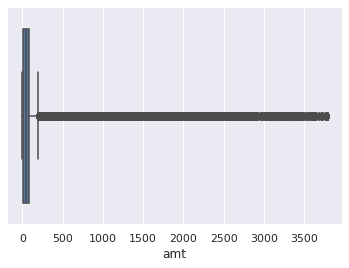

In [25]:
#Capping the outliers
master_df.loc[(master_df['amt'] > upper_bound),'amt'] = upper_bound

# Examing the box plot again
sns.boxplot(master_df['amt'])
plt.show()

**Observations:**

>Q3 value is set to 0.999 percentile so as to retain max amount of orignal informations. Also, amount is an important parameter to judge fradulent transactions

>By selecting Q3 as the above value, we are not loosing any orignal information which is flagged fradulent. Which in turns means that fradulent transaction don't have high amounts

>Outliers were capped. These capped records amount for 0.018% of the entire data

##### Population column

In [26]:
#Checking various percentile ranges
master_df['city_pop'].quantile([0.25,0.5,0.75,0.90,0.95,0.99,1])

0.25        741.0
0.50       2443.0
0.75      20328.0
0.90     186140.0
0.95     525713.0
0.99    1577385.0
1.00    2906700.0
Name: city_pop, dtype: float64

In [27]:
# Defining the quartile ranges
q1 = master_df['city_pop'].quantile(0.25)
q3 = master_df['city_pop'].quantile(0.99)

#Inspecting the records, and how many are flagged fraduent from them
pop_outliers = master_df[(master_df['city_pop'] > q3)]
pop_outliers.loc[pop_outliers['is_fraud'] == 1]

,cc_num,category,amt,gender,state,lat,long,city_pop,merch_lat,merch_long,is_fraud,Time_of_day,Week_day
2472,340187018810220,gas_transport,11.52,F,TX,29.4400,-98.4590,1595797,29.819364,-99.142791,1,Early_morning,3
2523,340187018810220,grocery_pos,276.31,F,TX,29.4400,-98.4590,1595797,29.273085,-98.836360,1,Early_morning,3
2553,340187018810220,grocery_pos,275.73,F,TX,29.4400,-98.4590,1595797,29.786426,-98.683410,1,Early_morning,3
3580,340187018810220,gas_transport,10.76,F,TX,29.4400,-98.4590,1595797,28.856712,-97.794207,1,Early_morning,4
3600,340187018810220,grocery_pos,332.35,F,TX,29.4400,-98.4590,1595797,29.320662,-97.937219,1,Early_morning,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176752,2296006538441789,shopping_net,915.63,F,NY,40.6816,-73.9798,2504700,40.983540,-73.090966,1,Evening,2
1176824,2296006538441789,shopping_net,979.39,F,NY,40.6816,-73.9798,2504700,40.431549,-73.365581,1,Evening,2
1177172,2296006538441789,grocery_pos,292.32,F,NY,40.6816,-73.9798,2504700,40.325958,-73.881193,1,Early_morning,3
1178432,2296006538441789,shopping_net,1016.17,F,NY,40.6816,-73.9798,2504700,41.182382,-74.698222,1,Evening,3


In [28]:
# Checking shape of the new outliers df
pop_outliers.shape

(16843, 13)

**Observations:**

>There are many records present even at the 99th percentile.

>Out of the records which are greater than third quartile, 83 of them are flagged as fraduent. By capping, significant information could be lost.

>Hence instead of going for outlier treatment by either capping & deleteing records, choosing to bin this column.

In [29]:
# Deleting outliers dataframe to release memory
del pop_outliers

In [30]:
# Binning population
master_df['Pop_bins'] = pd.cut(master_df['city_pop'],[-1,1274,6951,200420,2906700],labels = ['Low_pop','Med_pop', 'High_pop','VHigh_pop'])

#Checking the distribution of categories along the column
round(master_df['Pop_bins'].value_counts(normalize=True) * 100, 2)

Low_pop      35.04
Med_pop      31.96
High_pop     23.71
VHigh_pop     9.29
Name: Pop_bins, dtype: float64

In [31]:
# Converting the data type from category to object
master_df['Pop_bins'] = master_df['Pop_bins'].astype(object)

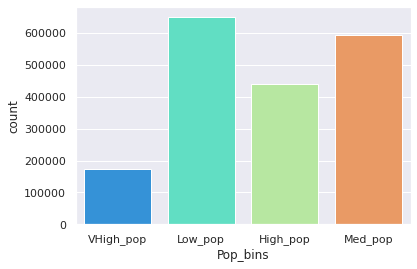

In [32]:
# Deleting the orignal column
master_df.drop('city_pop', axis = 1, inplace = True)

#Visualizing the bins
sns.countplot(x = 'Pop_bins', data = master_df, palette='rainbow')
plt.show()

### Univariate - Categorical analysis

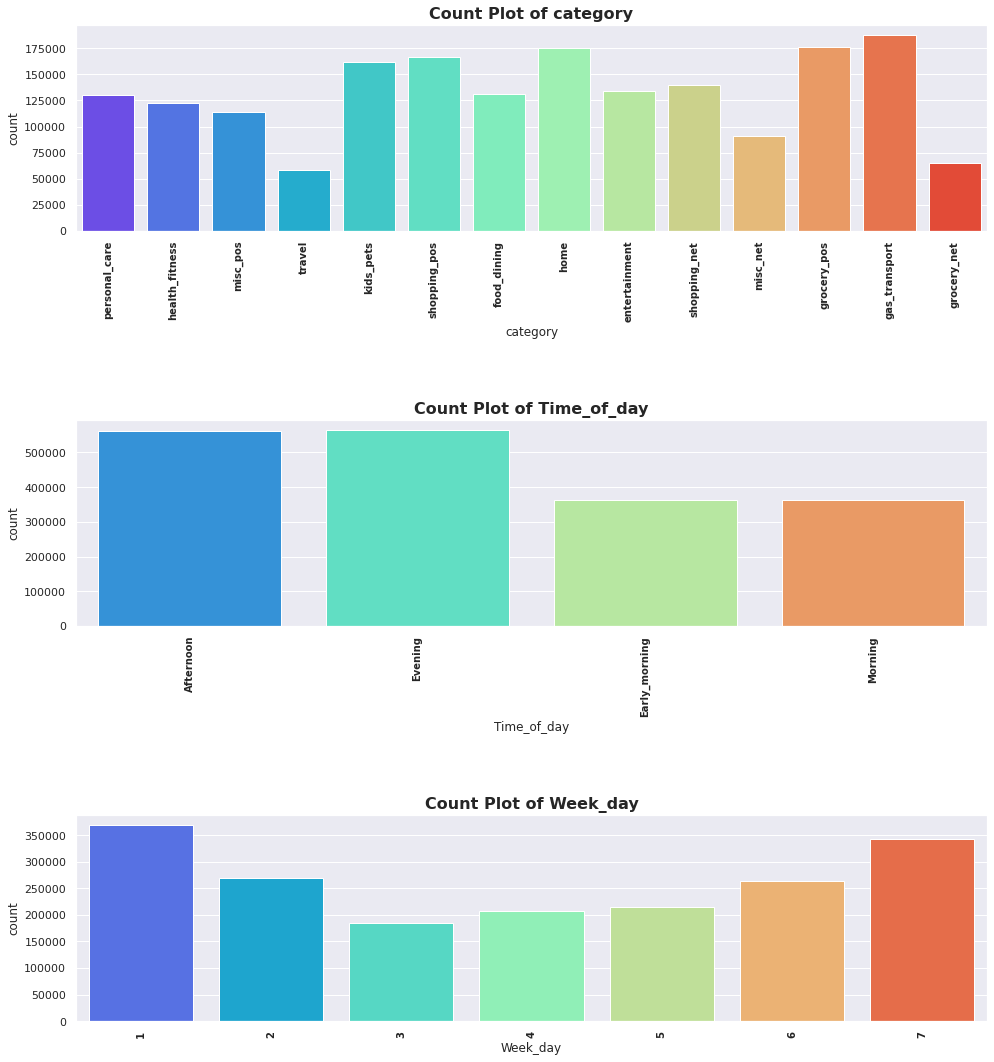

In [33]:
# Defining categorical variables for count plots
categorical_variables = ['category','Time_of_day', 'Week_day']

# Count plots
plt.figure(figsize = (15,15))
for var in enumerate(categorical_variables):
    plt.subplot(3,1,var[0]+1)
    plt.title("Count Plot of " + var[1], fontweight = 'bold', fontsize = 16)
    sns.countplot(master_df[var[1]],palette='rainbow')
    plt.xticks(fontsize = 10, rotation = 90, fontweight = 'bold')

    plt.tight_layout(pad=5.0)
    plt.subplots_adjust(top=1.0)

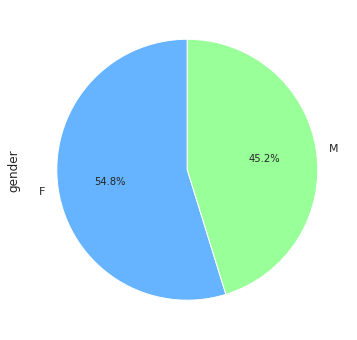

In [34]:
# Pie chart for plotting counts for gender column
plt.figure(figsize=(10,6))
colors = ['#66b3ff','#99ff99','#ffcc99','#ff9999', '#ffbb33', '#dda753']
master_df['gender'].value_counts().plot.pie(colors=colors, autopct='%1.1f%%', startangle=90)
plt.xticks(fontsize = 10, rotation = 90, fontweight = 'bold')
plt.show()

**Inferences:**

**1. Categories:**

> There are two seperate sub categories for misc i.e. misc_pos & misc_net

> There are two seperate sub categories for grocery i.e. grocery_pos grocery_net

>There are two seperate sub categories for shopping i.e. shopping_pos &  shopping_net

>Treating these two categories by combining it into respective categories i.e. misc, shopping and grocery

**2. Time_of_day:**

>  More number of transactions were made in afternoon and evening ascompared to morning and early morning which is obvious.

**3. Week_day:**

> Mid week i.e. from tuesday to friday there are less number of transactions been made as compared to monday, saturday & sunday

**Gender:**

> 9% more transactions are done by females as comapared to males



In [35]:
# Fixing the two subcategories for the category column
master_df.loc[(master_df['category'] == 'grocery_pos')  ,'category'] = 'grocery'
master_df.loc[(master_df['category'] == 'grocery_net')  ,'category'] = 'grocery'
master_df.loc[(master_df['category'] == 'misc_pos')  ,'category'] = 'misc'
master_df.loc[(master_df['category'] == 'misc_net')  ,'category'] = 'misc'
master_df.loc[(master_df['category'] == 'shopping_pos')  ,'category'] = 'shopping'
master_df.loc[(master_df['category'] == 'shopping_net')  ,'category'] = 'shopping'

In [36]:
# Checking the counts now
master_df['category'].value_counts()

shopping          305785
grocery           241069
misc              204883
gas_transport     188029
home              175460
kids_pets         161727
entertainment     134118
food_dining       130729
personal_care     130085
health_fitness    122553
travel             57956
Name: category, dtype: int64

### Bivariate Analysis

#### Categorical columns with target

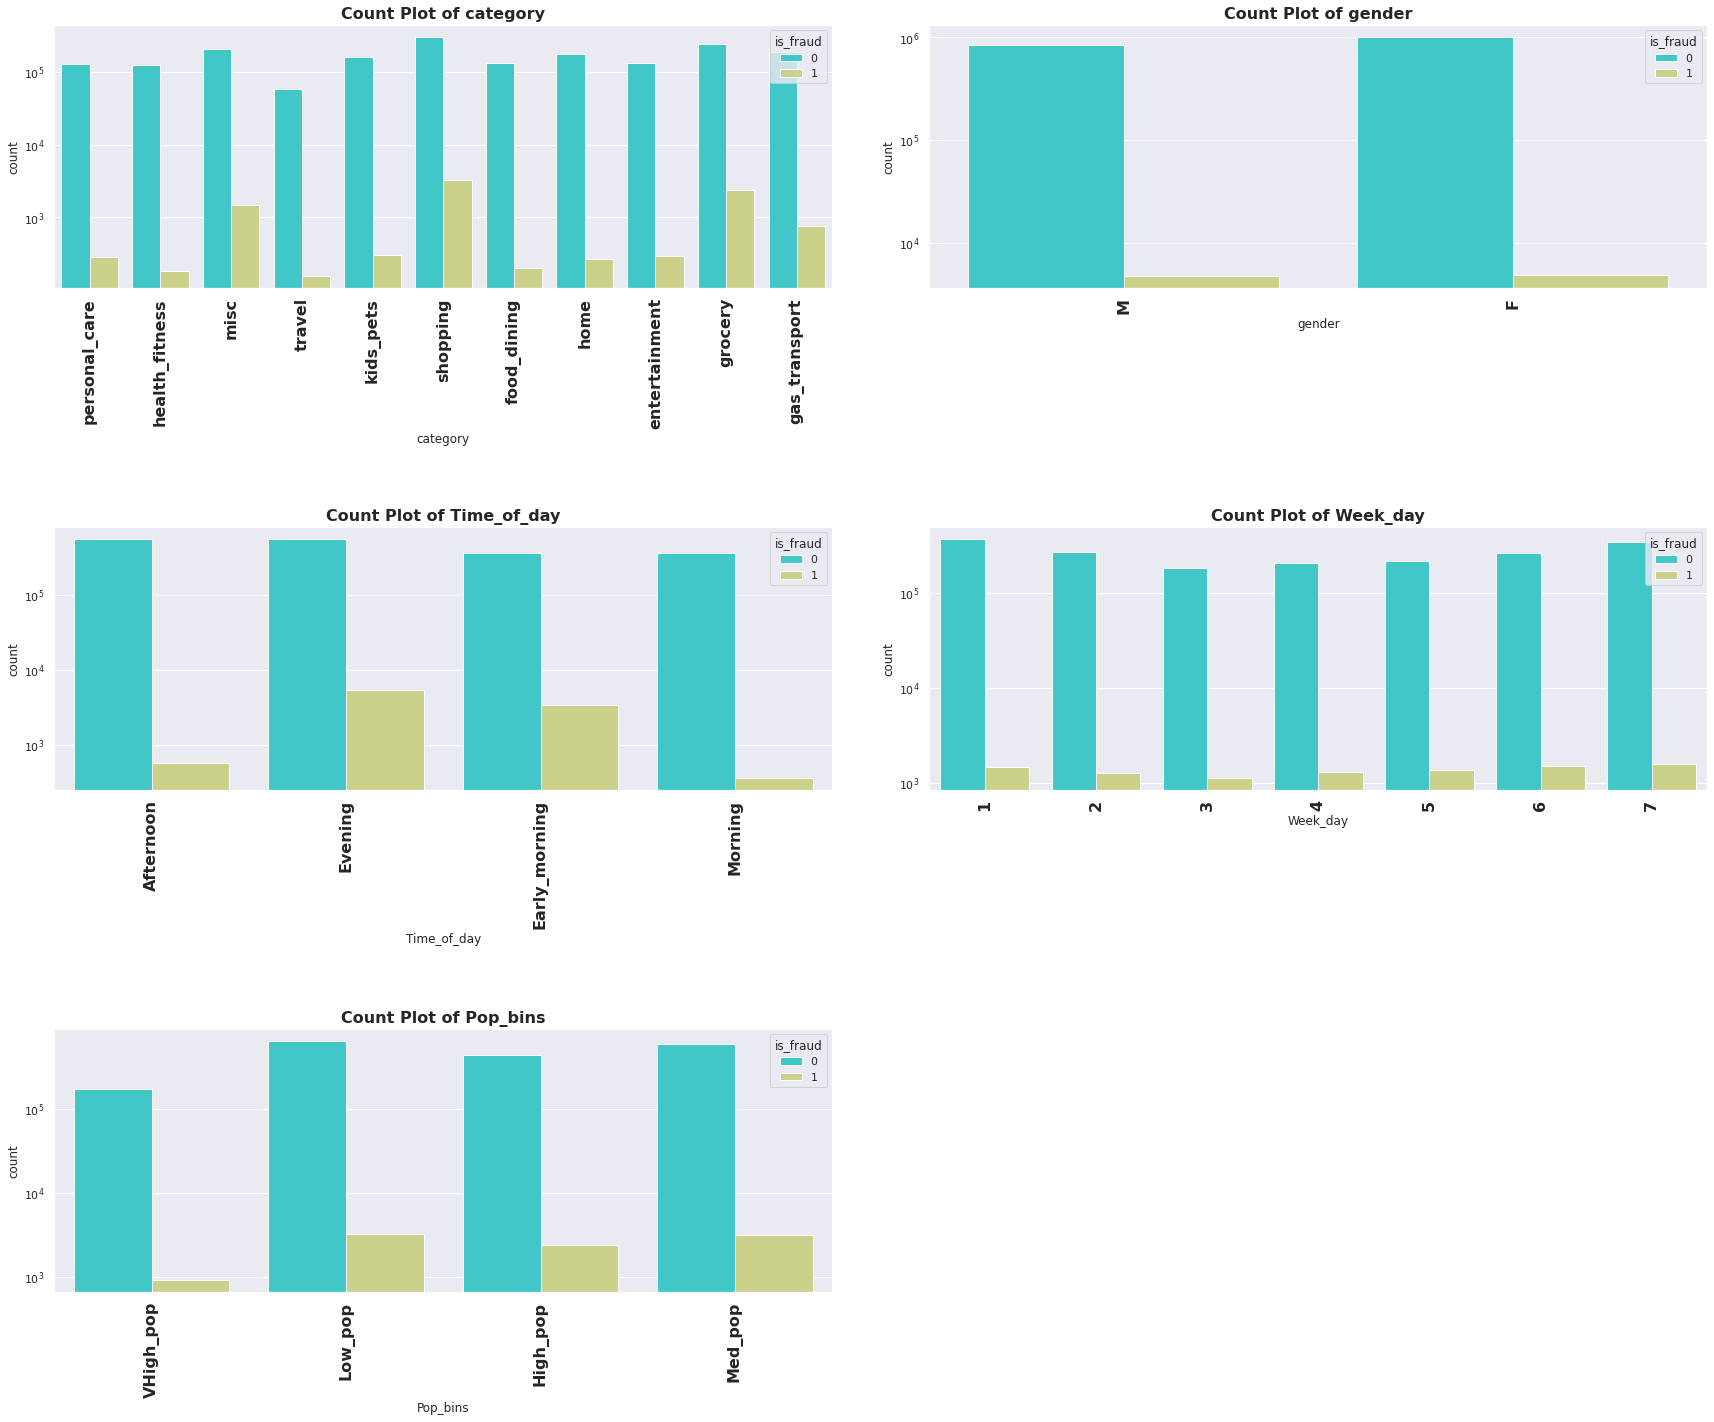

In [37]:
# Defining categorical variables 
categorical_variables = ['category','gender','Time_of_day', 'Week_day','Pop_bins']
# Count plots
plt.figure(figsize = (25,20))
for var in enumerate(categorical_variables):
    plt.subplot(3,2,var[0]+1)
    plt.title("Count Plot of " + var[1], fontweight = 'bold', fontsize = 16)
    sns.countplot(master_df[var[1]],palette='rainbow', hue = master_df['is_fraud'])
    plt.yscale('log')
    plt.xticks(fontsize = 16, rotation = 90, fontweight = 'bold')

    plt.tight_layout(pad=5.0)
    plt.subplots_adjust(top=1.0)


**Significant Observations**

**1. Category**

> There are more frauds happening while shopping, paying for groceries & transporting gas

**2. Time of day**

> Frauds are significantly higher during eveng and early morning hours of the day

#### Numerical columns with target

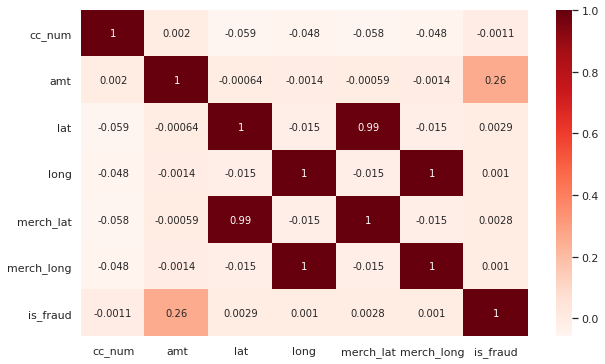

In [38]:
# Plotting pair plot to check co realtion with target variable
plt.figure(figsize=(10,6))
sns.heatmap(master_df.corr(), cmap='Reds', annot=True)
plt.show()

**Significant Observations**

> Longitutdes & lattitudes have highest co relation - For obvious reasons

> Amount and target column are positvely correlated with max correlation as comapred to other variables


### Multivariate 

#### Categorical - Numerical

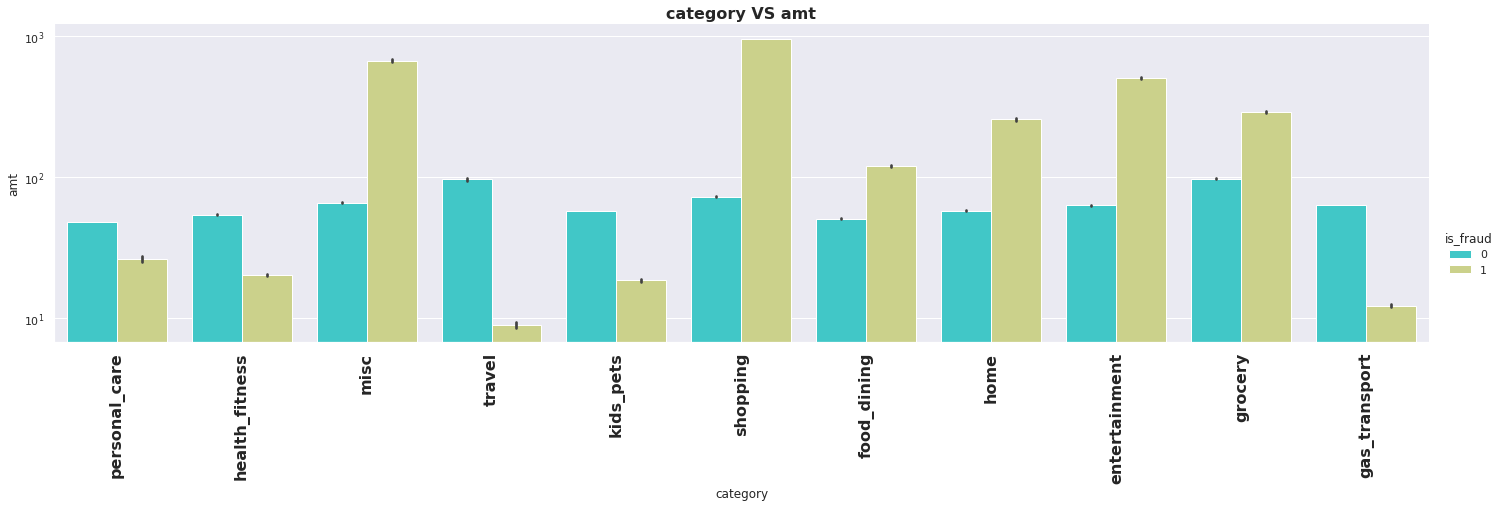

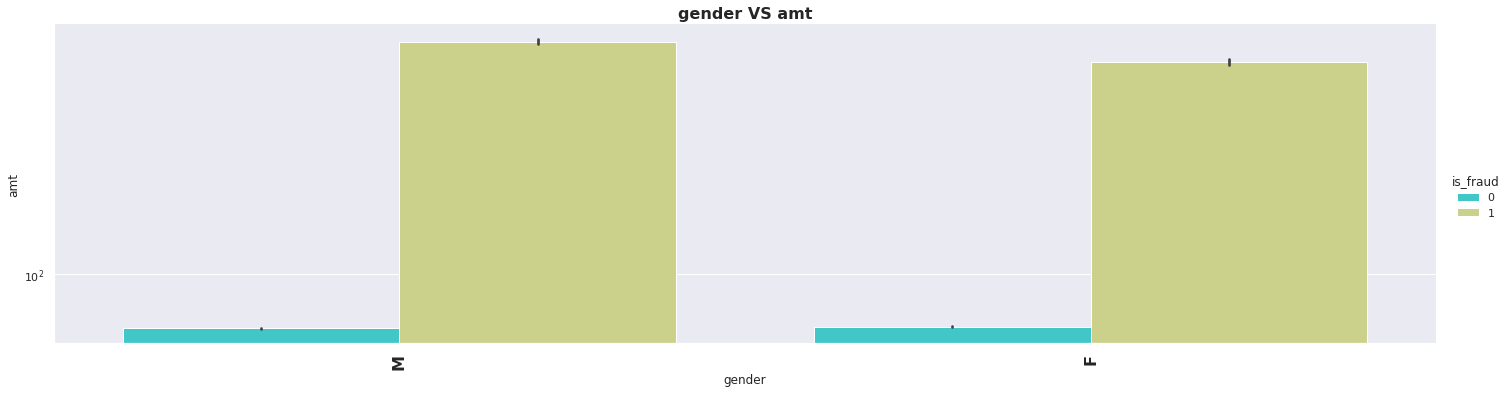

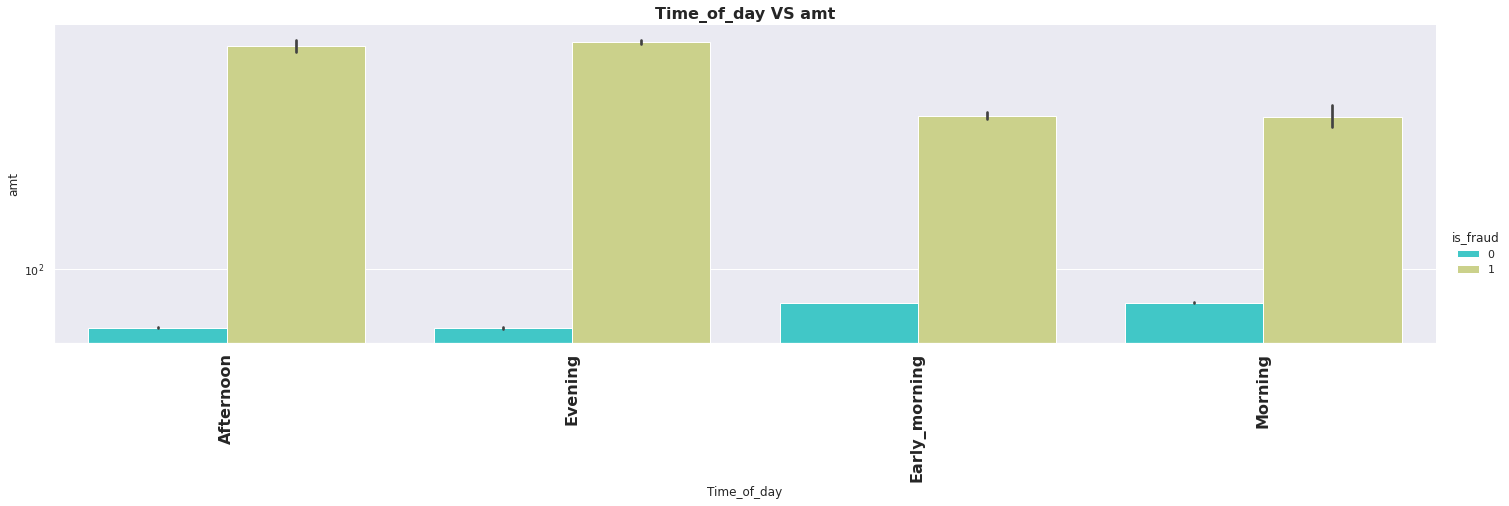

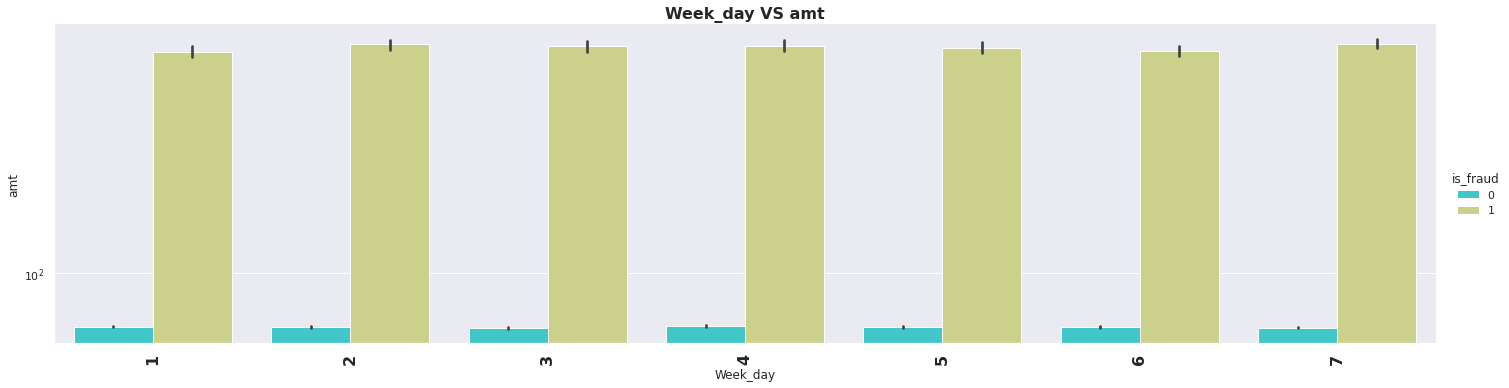

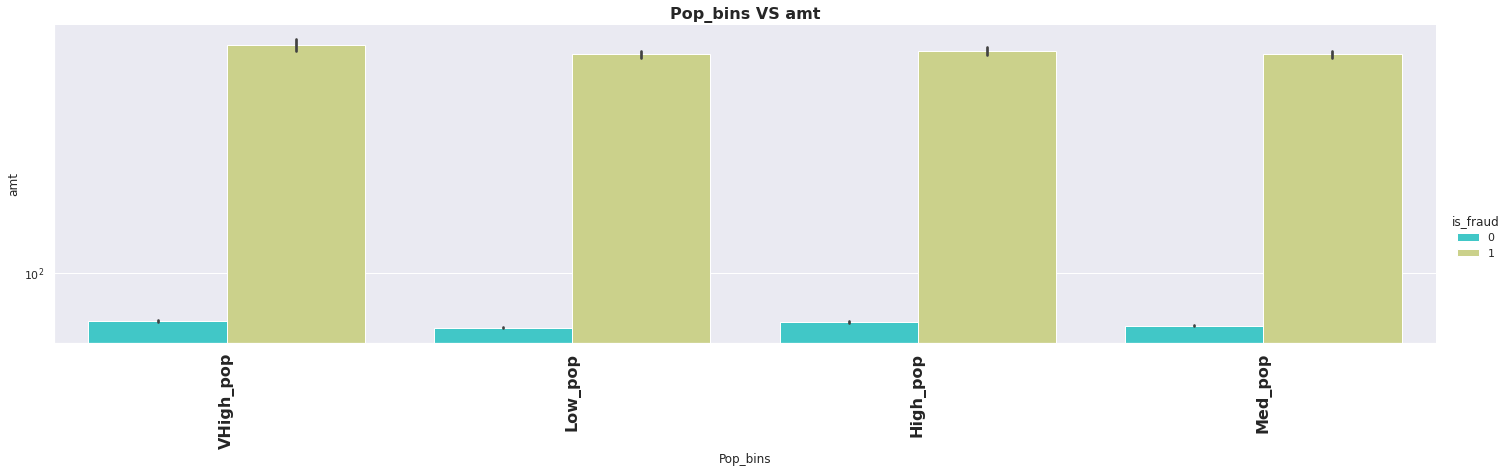

In [39]:
cat_cols1 = ['category', 'gender', 'Time_of_day','Week_day','Pop_bins']
num_cols1 = ['amt']

for i in range(len(cat_cols1)):
    cat_col = cat_cols1[i]
    for j in range(len(num_cols1)):
        num_col = num_cols1[j]
        sns.catplot(x= cat_col, y = num_col, hue = 'is_fraud', kind = 'bar', data = master_df, aspect=4, palette='rainbow')
        plt.xticks(rotation=90, fontweight = 'bold', fontsize = 16)
        plt.yscale('log')
        plt.title(cat_col+ ' VS ' + num_col, fontweight = 'bold', fontsize= 16)
        plt.show()

**Observations:**

**1. Category Vs Amount**

> More amount is being lost to frauds while shopping, dining, entertainment, buying groceries & home products as compared to other categories such as travel, health fitness etc.

**2. All other categories**

> Irrespective of time & day when transactions are taking place, overall amount being lost to frauds is higher though the transactions per amount is lower.



#### Categorical - Categorical

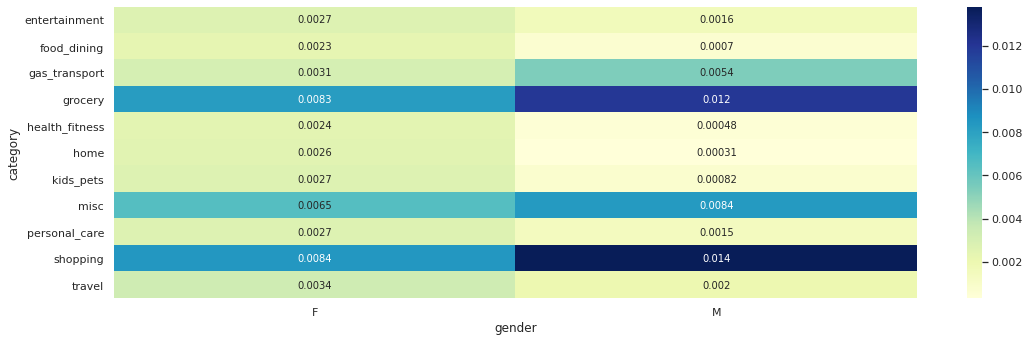

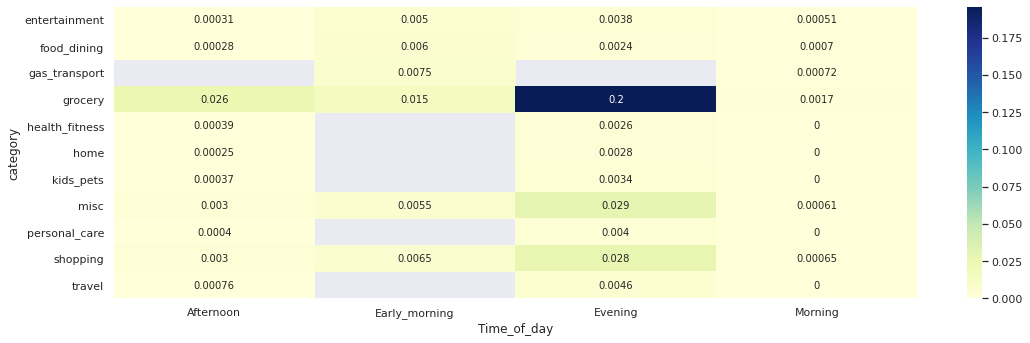

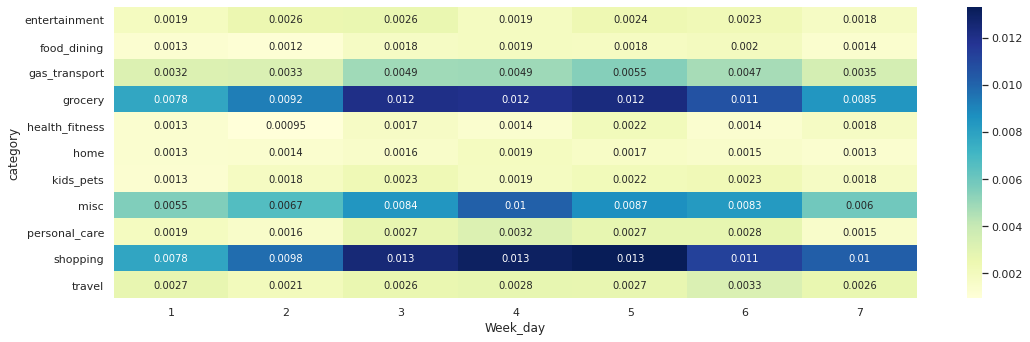

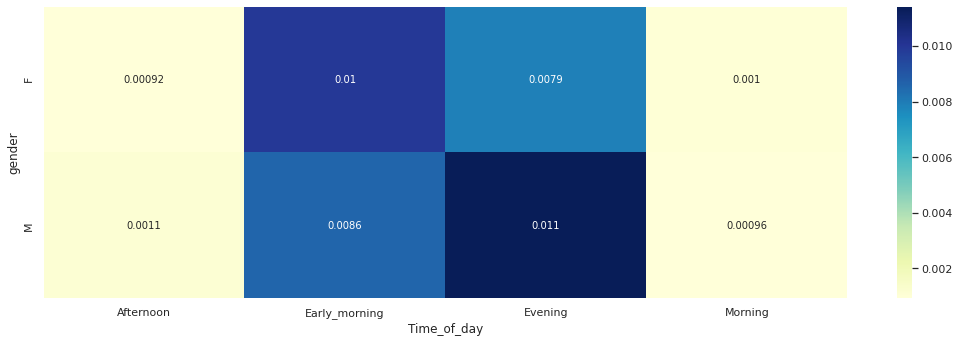

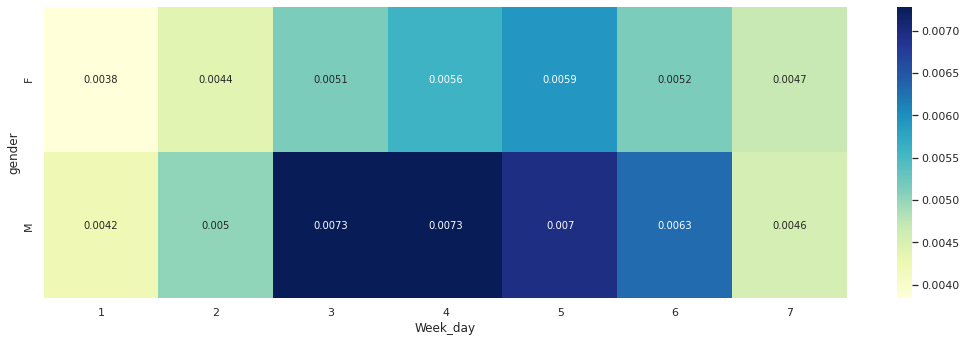

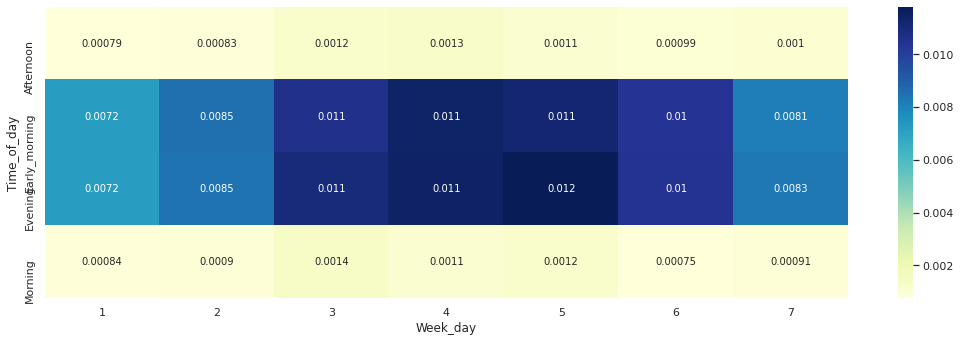

In [40]:
cat_cols = ['category', 'gender', 'Time_of_day', 'Week_day']

l = len(cat_cols)

for i in range(l):
    col1 = cat_cols[i]
    for j in range(i,l):
        if i!=j:
            col2 = cat_cols[j]
            res = pd.pivot_table(data=master_df, index=col1, columns=col2, values='is_fraud')
            plt.figure(figsize = (18,6))
            sns.heatmap(res, annot=True, cmap='YlGnBu')
            plt.subplots_adjust(top=0.8)
            plt.show()

**Observations:**

**1. Gender vs Time of the day**

> More frauds happening early morning & druring evening times irrespective of the gender.

**2. Gender vs Day of the week**

> Fraud counts are more from Wednesday to Saturday in case of males as compared to females

**3. Category vs gender**

> Fraud counts are more in shopping & grocery categories. They are more in case of males are compared to females

**4. Category vs time of the day**

>  Fraud counts are more when the category is grocery and time of the day is evening.

**5. Category vs week of the day**

> Fraud counts are more when during mid week i.e. wednesday to saturday for categories shopping, grocery & misc

**6. Time of the day vs week day**

> During early morning & eveng hours, from wed to friday the fraud counts are more

#### Numerical - Numerical

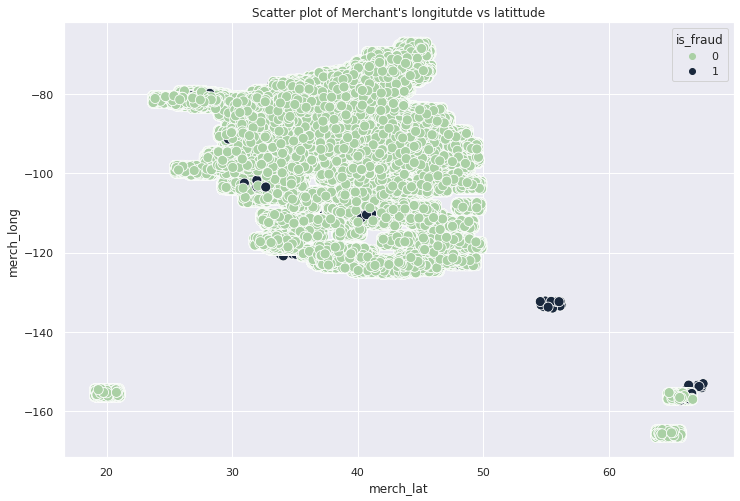

In [41]:
# Scatter plot of Merchant's lontitde vs latitdue to check which locations have max fradulent transactions
plt.figure(figsize=(12,8))
sns.scatterplot(x = 'merch_lat', y = 'merch_long', hue = 'is_fraud', data = master_df, s = 100, palette="ch:r=-.5,l=.75")
plt.title("Scatter plot of Merchant's longitutde vs latittude")
plt.show()

**Observation:**

> One set of frauds that are happening have completely different lattitudes & longitudes

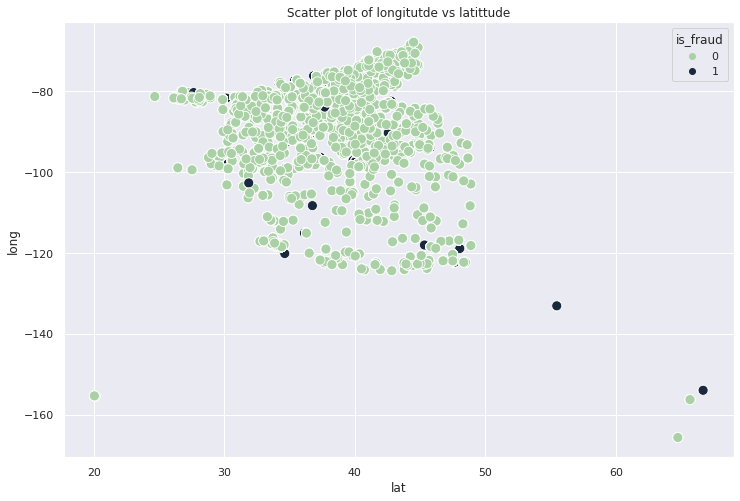

In [42]:
# Scatter plot of lontitde vs latitdue to check which locations have max fradulent transactions
plt.figure(figsize=(12,8))
sns.scatterplot(x = 'lat', y = 'long', hue = 'is_fraud', data = master_df,  s = 100, palette="ch:r=-.5,l=.75")
plt.title("Scatter plot of longitutde vs latittude")
plt.show()

**Observation:**

> Just few frauds are having latitudes and longitudes that appear totally different.

> Most frauds have the same laitudes & longitudes as the non fraudulent transactions making it difficult to identify fraud transactions 

# Data Prep

## Skewness check

In [43]:
# Removing city pop from num vars as that column has been dropped
numvars.remove('city_pop')

# Checking for skewness in all the columns of the dataframe
master_df.skew(axis = 0)

cc_num         2.851074
amt           11.635161
lat           -0.191999
long          -1.146919
merch_lat     -0.188097
merch_long    -1.143933
is_fraud      13.745675
Week_day       0.007780
dtype: float64

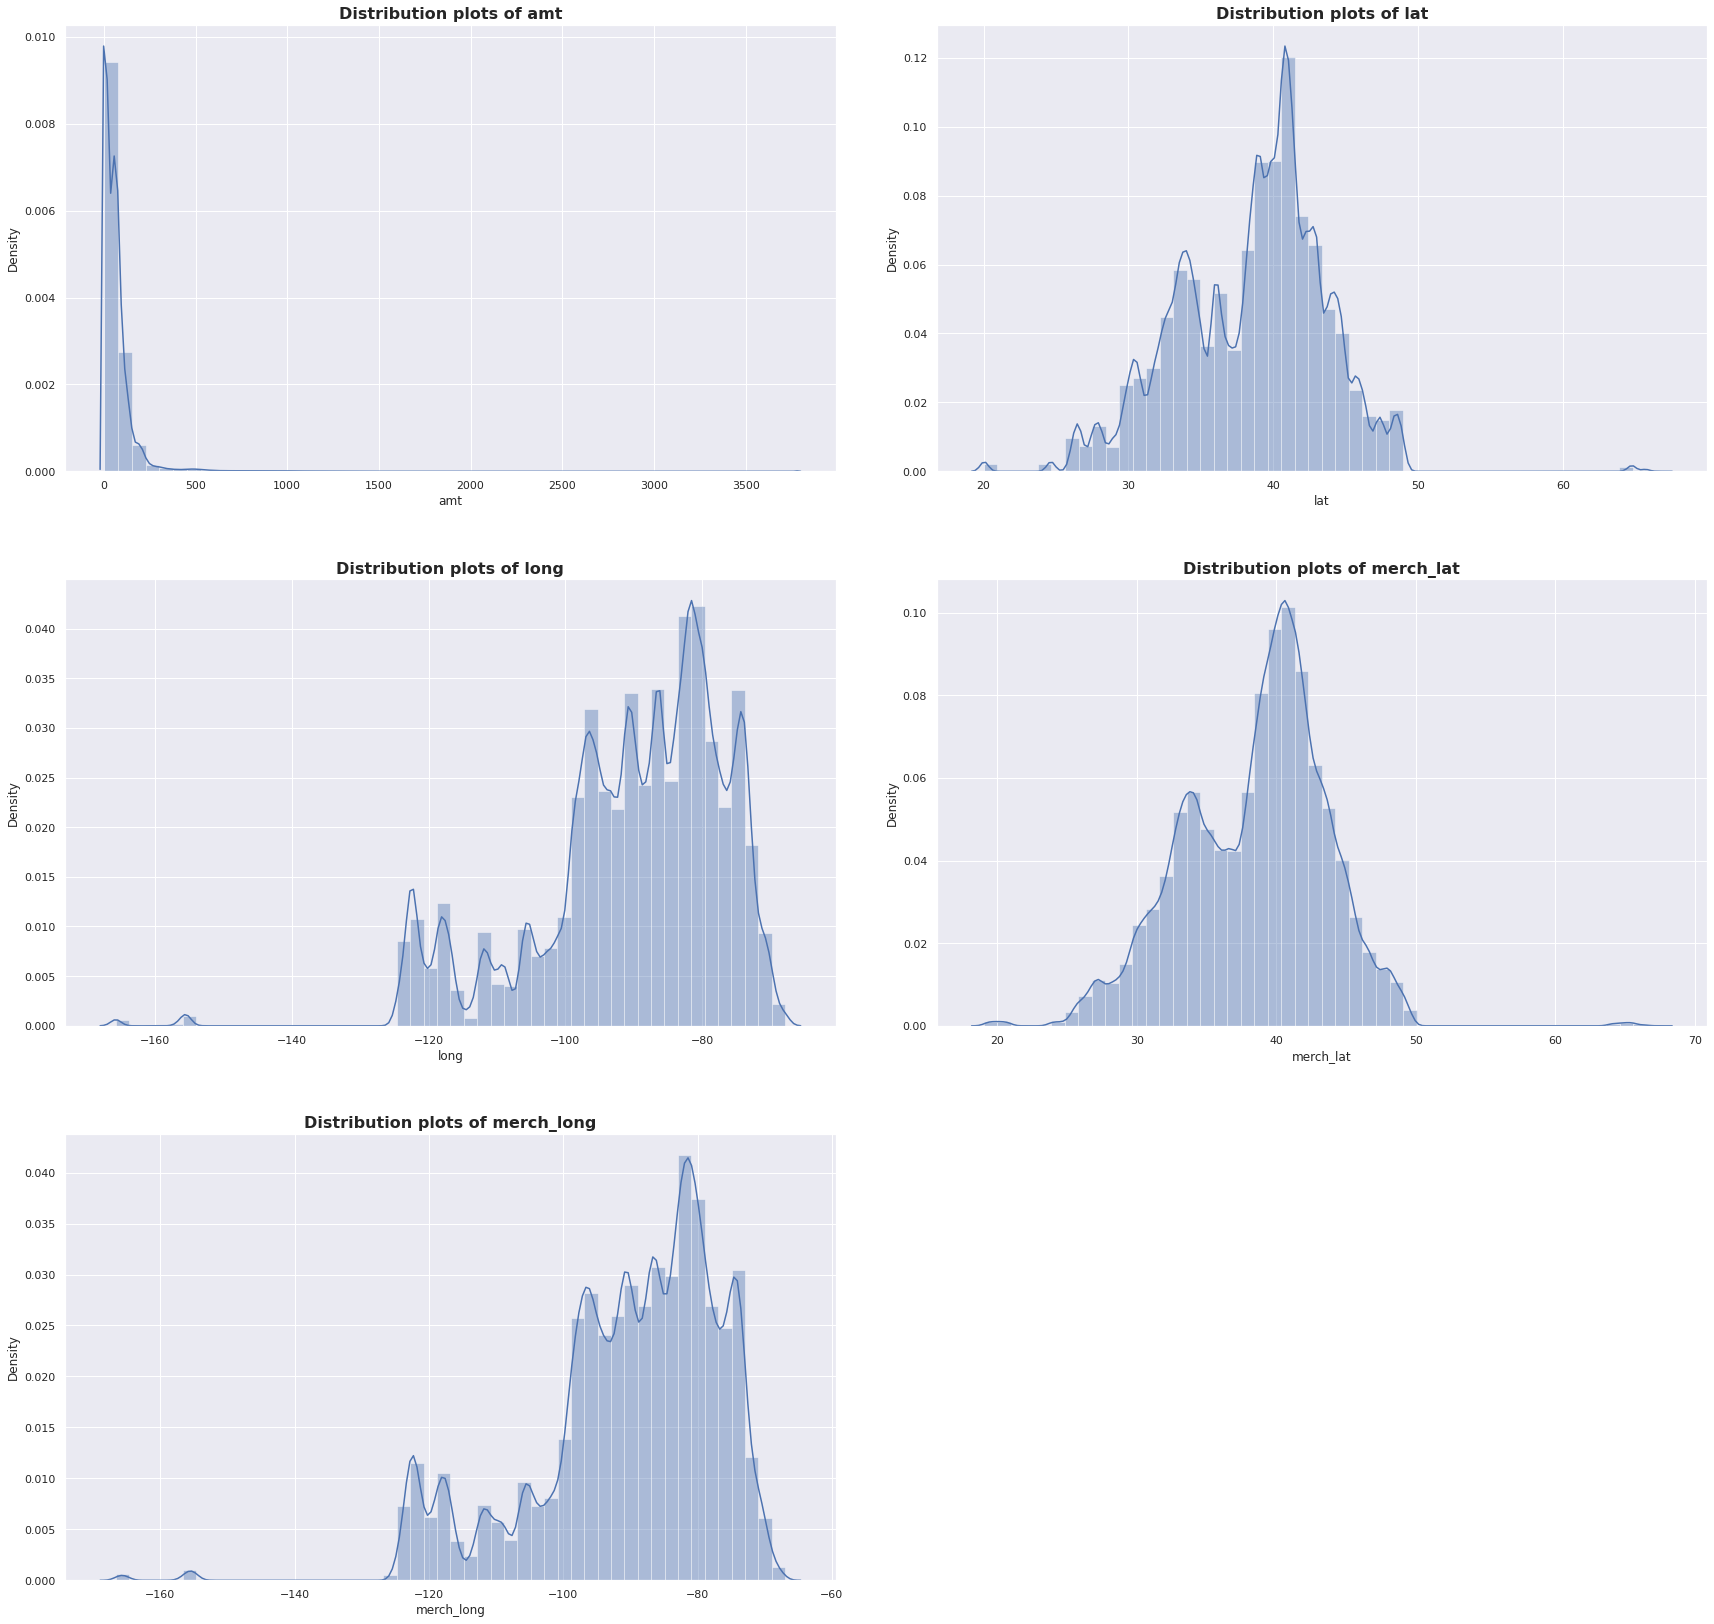

In [44]:
# Visualizing the skewness for each column
plt.figure(figsize = (25,30))
for var in enumerate(numvars):
    plt.subplot(4,2,var[0]+1)
    plt.title("Distribution plots of " + var[1], fontweight = 'bold', fontsize = 16)
    sns.distplot(master_df[var[1]])
    
    plt.tight_layout(pad=5.0)
    plt.subplots_adjust(top=1.0)

**Observation:**
>The data is skewed.

>Some are left skewed and while some are right skewed.

>Will deal with skewness by applying power transformation once we split the data into train and test sets


## Creating Dummy Variables

In [45]:
# Creating a new data frame for model building
model_df = master_df.drop(['state','cc_num'], axis = 1)
model_df.head(2)

,category,amt,gender,lat,long,merch_lat,merch_long,is_fraud,Time_of_day,Week_day,Pop_bins
0,personal_care,2.86,M,33.9659,-80.9355,33.986391,-81.200714,0,Afternoon,7,VHigh_pop
1,personal_care,29.84,F,40.3207,-110.4360,39.450498,-109.960431,0,Afternoon,7,Low_pop


In [46]:
# Converting gender to binary 
model_df.gender = model_df.gender.map({'M': 0, 'F': 1})
model_df.head(2)

,category,amt,gender,lat,long,merch_lat,merch_long,is_fraud,Time_of_day,Week_day,Pop_bins
0,personal_care,2.86,0,33.9659,-80.9355,33.986391,-81.200714,0,Afternoon,7,VHigh_pop
1,personal_care,29.84,1,40.3207,-110.4360,39.450498,-109.960431,0,Afternoon,7,Low_pop


In [47]:
# Find all categorical variables & storing it as a list
cat_vars = model_df.select_dtypes('object').columns.to_list()

# Create dummies
model_cat = pd.get_dummies(model_df[cat_vars], drop_first=True)
model_cat

# Add dummy columns
model_df = pd.concat([model_df, model_cat], axis=1)

#Drop original columns
model_df.drop(cat_vars, axis=1, inplace=True)

# checking few rows
model_df.head()

,amt,gender,lat,long,merch_lat,merch_long,is_fraud,category_food_dining,category_gas_transport,category_grocery,category_health_fitness,category_home,category_kids_pets,category_misc,category_personal_care,category_shopping,category_travel,Time_of_day_Early_morning,Time_of_day_Evening,Time_of_day_Morning,Week_day_2,Week_day_3,Week_day_4,Week_day_5,Week_day_6,Week_day_7,Pop_bins_Low_pop,Pop_bins_Med_pop,Pop_bins_VHigh_pop
0,2.86,0,33.9659,-80.9355,33.986391,-81.200714,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,29.84,1,40.3207,-110.4360,39.450498,-109.960431,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
2,41.28,1,40.6729,-73.5365,40.495810,-74.196111,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,60.05,0,28.5697,-80.8191,28.812398,-80.883061,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,3.19,0,44.2529,-85.0170,44.959148,-85.884734,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0


## Creating X & Y dataframes

In [48]:
# Removing the target column
X = model_df.drop('is_fraud', axis = 1)
X.head(2)

,amt,gender,lat,long,merch_lat,merch_long,category_food_dining,category_gas_transport,category_grocery,category_health_fitness,category_home,category_kids_pets,category_misc,category_personal_care,category_shopping,category_travel,Time_of_day_Early_morning,Time_of_day_Evening,Time_of_day_Morning,Week_day_2,Week_day_3,Week_day_4,Week_day_5,Week_day_6,Week_day_7,Pop_bins_Low_pop,Pop_bins_Med_pop,Pop_bins_VHigh_pop
0,2.86,0,33.9659,-80.9355,33.986391,-81.200714,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,29.84,1,40.3207,-110.4360,39.450498,-109.960431,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [49]:
# Defining the target variable
y = model_df['is_fraud']
y.head(2)

0    0
1    0
Name: is_fraud, dtype: int64

## Test Train split

In [50]:
# Splitting into test & train sets
X_train, X_test, y_train,y_test = train_test_split(X,y,train_size = 0.7,stratify = y, random_state = 100)

# Printing the test, train shapes
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (1296675, 28)
X_test shape:  (555719, 28)
y_train shape:  (1296675,)
y_test shape:  (555719,)


In [51]:
# Checking the split on train set
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 1289919, 1: 6756}

In [52]:
# Checking the split on train set
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 552824, 1: 2895}

## Power transformation

In [53]:

# Initializing power transformer
pt = PowerTransformer(method = 'yeo-johnson', standardize= True)

#Fitting power transformer on the train data set
X_train[numvars] = pt.fit_transform(X_train[numvars])

# Power transformation on the test data set
X_test[numvars] = pt.transform(X_test[numvars])


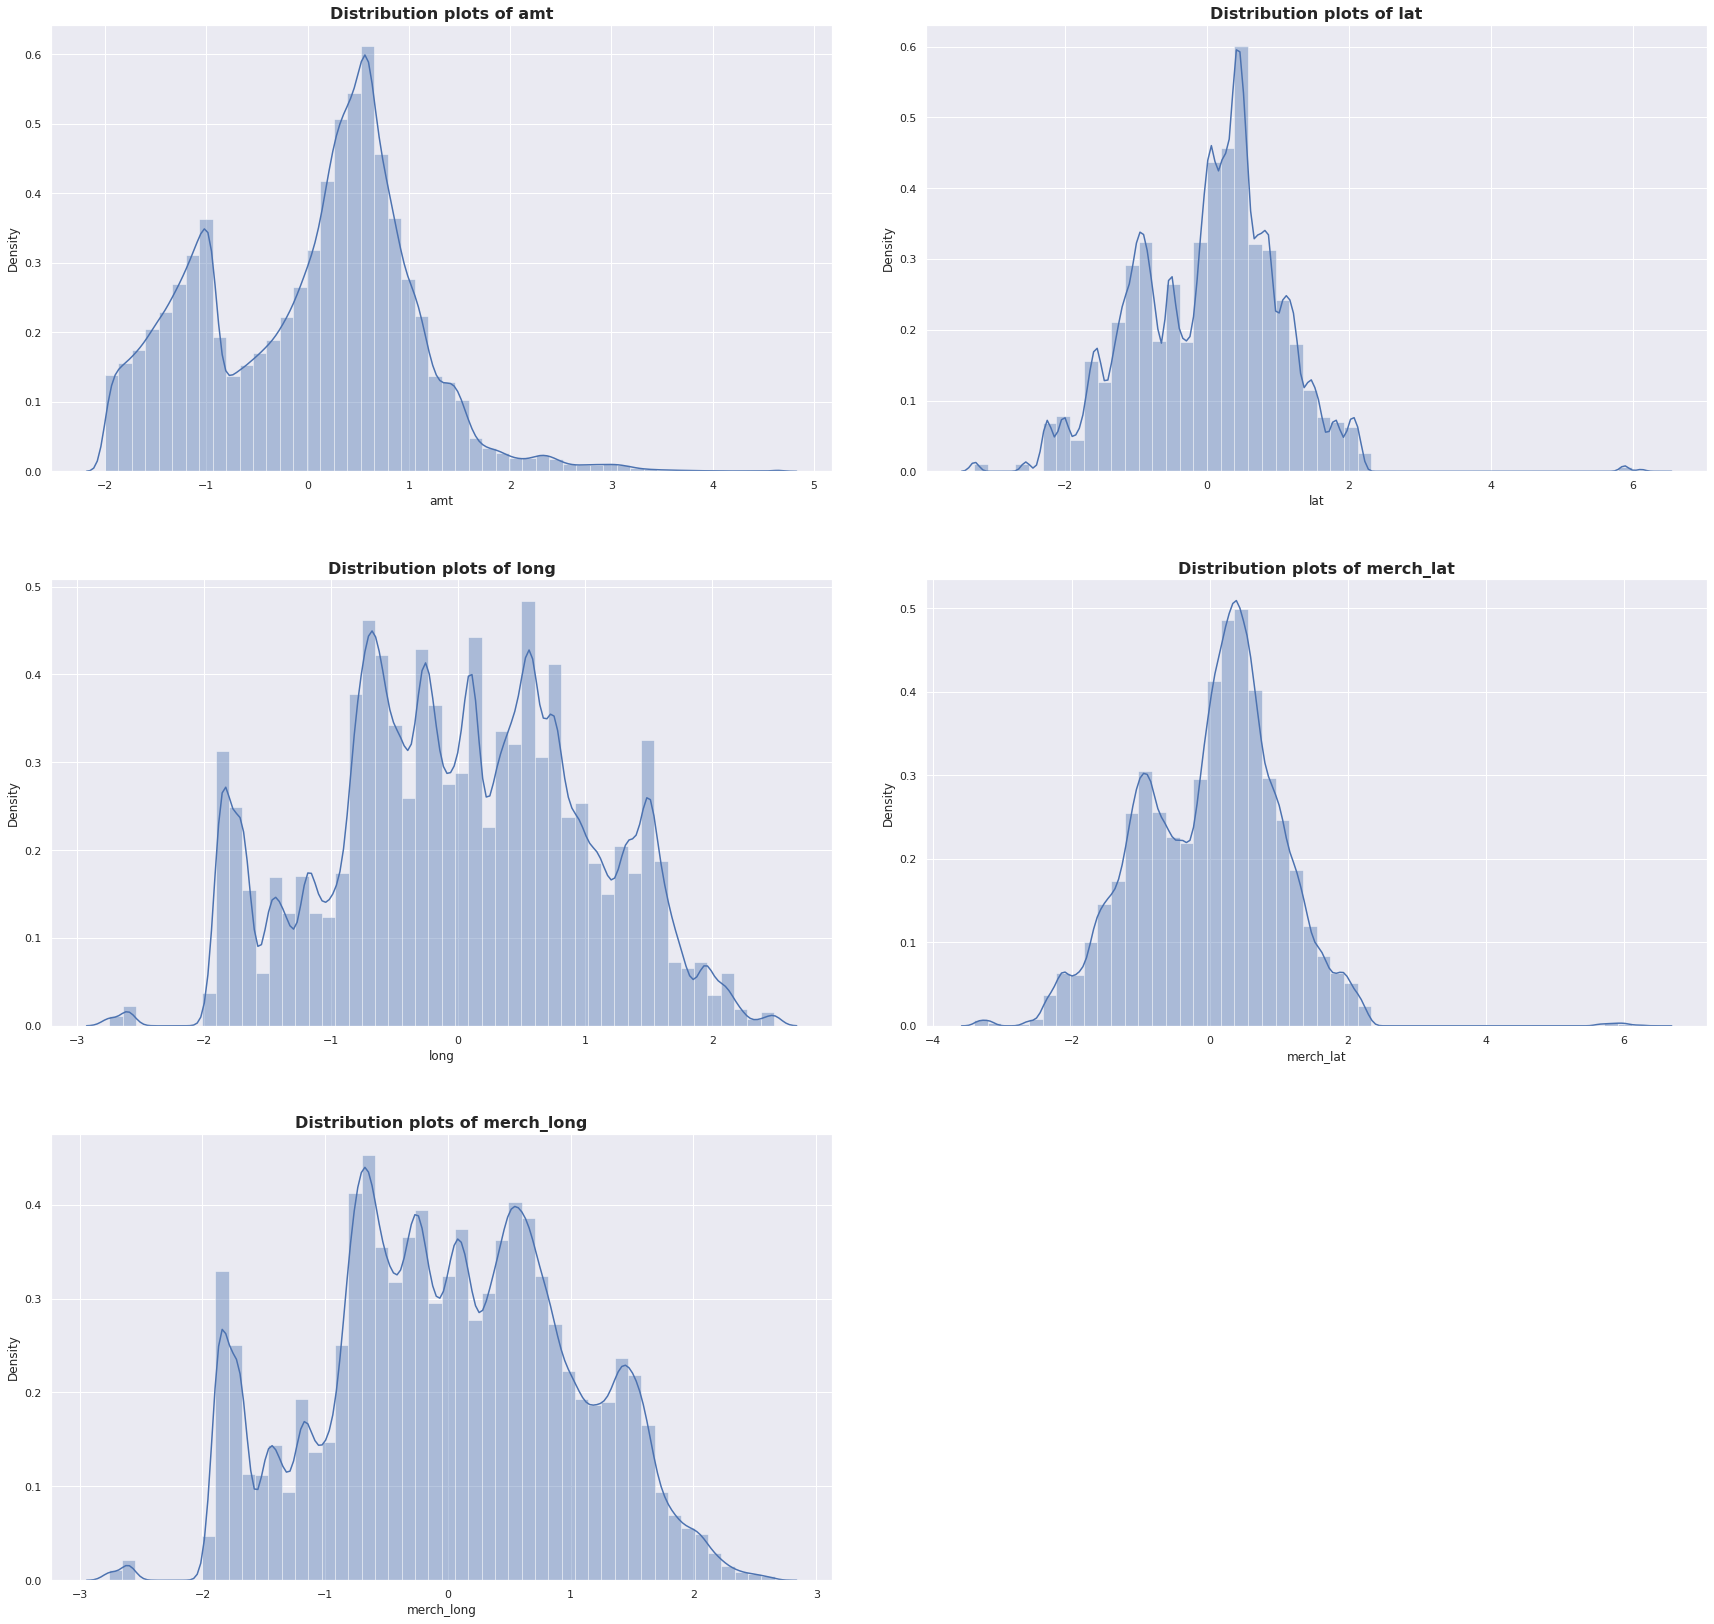

In [54]:
# Checking the data again after power transformation
plt.figure(figsize = (25,30))
for var in enumerate(numvars):
    plt.subplot(4,2,var[0]+1)
    plt.title("Distribution plots of " + var[1], fontweight = 'bold', fontsize = 16)
    sns.distplot(X_train[var[1]])
    
    plt.tight_layout(pad=5.0)
    plt.subplots_adjust(top=1.0)

**Observation:**

>After performing power transformation, the data now somewhat looks like normal distributions

>By performing this step, we have handled skewness

>Once power transformation is done, all the numerical variables get reduced to a certain scale.

>This eliminates the need for performing scaling.

## Balancing data by using ADASYN

In [55]:
# Using ADASYN to balance to the dataset
X_train_ada, y_train_ada = ADASYN().fit_resample(X_train, y_train)

#Converting X_train_ada & y_train_ada into dataframes
X_train_ada = pd.DataFrame(X_train_ada)
y_train_ada = pd.DataFrame(y_train_ada)

#Checking the shape
print('X_train_ada shape: ', X_train_ada.shape)
print('y_train_ada shape: ', y_train_ada.shape)

X_train_ada shape:  (2578802, 28)
y_train_ada shape:  (2578802, 1)


In [56]:
# Renaming columns
cols = X_train.columns.to_list()
X_train_ada.columns = cols
y_train_ada.columns = ['is_fraud']
X_train_ada.head(2)

,amt,gender,lat,long,merch_lat,merch_long,category_food_dining,category_gas_transport,category_grocery,category_health_fitness,category_home,category_kids_pets,category_misc,category_personal_care,category_shopping,category_travel,Time_of_day_Early_morning,Time_of_day_Evening,Time_of_day_Morning,Week_day_2,Week_day_3,Week_day_4,Week_day_5,Week_day_6,Week_day_7,Pop_bins_Low_pop,Pop_bins_Med_pop,Pop_bins_VHigh_pop
0,1.345267,1.0,-1.072371,0.345097,-1.237858,0.286055,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-1.145566,0.0,0.402178,-0.406416,0.374063,-0.334375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [57]:
#Checking imabalnce ratio
(y_train_ada['is_fraud'].value_counts(normalize = True))*100

0    50.020087
1    49.979913
Name: is_fraud, dtype: float64

**Observation:**
1. After performing ADASYN on the train set, we can now see that the data is balanced.
2. Going ahead with building different models now

# Models


## Logistic Models

#### Logistic Regression with ADASYN balancing technique

##### Building Model

In [58]:
# Instantiate Logistic Regression
log_reg = LogisticRegression()

# Applying RFE on train set with top 15 columns
rfe = RFE(log_reg,15).fit(X_train_ada,y_train_ada)

In [59]:
#RFE support columns retained in variable cols
cols = X_train_ada.columns[rfe.support_]
cols

Index(['amt', 'gender', 'category_food_dining', 'category_gas_transport',
       'category_grocery', 'category_health_fitness', 'category_kids_pets',
       'category_misc', 'category_personal_care', 'category_shopping',
       'category_travel', 'Time_of_day_Early_morning', 'Time_of_day_Evening',
       'Time_of_day_Morning', 'Week_day_5'],
      dtype='object')

In [60]:
#Builing statistical logistic model

X_train_ada_sm = sm.add_constant(X_train_ada[cols])
log_model = sm.GLM(y_train_ada, X_train_ada_sm, family=sm.families.Binomial()).fit()
print(log_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               is_fraud   No. Observations:              2578802
Model:                            GLM   Df Residuals:                  2578786
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1621e+06
Date:                Sun, 03 Jan 2021   Deviance:                   2.3241e+06
Time:                        07:43:54   Pearson chi2:                 2.36e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [61]:
# Defining a function to check the VIF of the features
def check_vif():
    vif = pd.DataFrame()
    vif['Features'] = X_train_ada[cols].columns
    vif['VIF'] = [variance_inflation_factor(X_train_ada[cols].values, i) for i in range (X_train_ada[cols].shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by = 'VIF', ascending = False)
    return vif

# Calling the function to check VIF
check_vif()

,Features,VIF
11,Time_of_day_Early_morning,4.21
4,category_grocery,3.33
12,Time_of_day_Evening,2.65
3,category_gas_transport,2.27
13,Time_of_day_Morning,2.26
1,gender,2.24
9,category_shopping,2.01
7,category_misc,1.86
0,amt,1.68
6,category_kids_pets,1.26


**Comments:**

> All the p- values are less than 0.05 and hence significant

>The VIF's are also below 5. Which means no collinearity exits in the model

>Dropping category misc since this variable won't be suitable for business

In [62]:
# Dropping column as it does it is not relevant for business in specific
cols = cols.drop('category_misc')

# Again rebuilding the model
X_train_ada_sm = sm.add_constant(X_train_ada[cols])
log_model = sm.GLM(y_train_ada, X_train_ada_sm, family=sm.families.Binomial()).fit()
print(log_model.summary())

# Checking VIFs
check_vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:               is_fraud   No. Observations:              2578802
Model:                            GLM   Df Residuals:                  2578787
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1976e+06
Date:                Sun, 03 Jan 2021   Deviance:                   2.3952e+06
Time:                        07:45:19   Pearson chi2:                 2.43e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
10,Time_of_day_Early_morning,3.01
4,category_grocery,2.37
1,gender,2.21
11,Time_of_day_Evening,2.21
3,category_gas_transport,1.80
12,Time_of_day_Morning,1.73
0,amt,1.64
8,category_shopping,1.58
6,category_kids_pets,1.21
7,category_personal_care,1.20


**Comments:**

> All VIF's are below 5 which says multicollineaity dosen't exists.

> The p - value of category_shopping variable is 0.508 which is greater than 0.05, causing the p - value to be insignificant

> Hence dropping category_shopping and again rebuilding the model

In [63]:
# Dropping column as it does it's p - value is not significant
cols = cols.drop('category_shopping')

# Again rebuilding the model
X_train_ada_sm = sm.add_constant(X_train_ada[cols])
log_model = sm.GLM(y_train_ada, X_train_ada_sm, family=sm.families.Binomial()).fit()
print(log_model.summary())

# Checking VIFs
check_vif()

                 Generalized Linear Model Regression Results                  
Dep. Variable:               is_fraud   No. Observations:              2578802
Model:                            GLM   Df Residuals:                  2578788
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1976e+06
Date:                Sun, 03 Jan 2021   Deviance:                   2.3952e+06
Time:                        07:46:32   Pearson chi2:                 2.43e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
9,Time_of_day_Early_morning,2.83
1,gender,2.15
4,category_grocery,2.09
10,Time_of_day_Evening,2.06
3,category_gas_transport,1.71
11,Time_of_day_Morning,1.63
0,amt,1.56
6,category_kids_pets,1.19
7,category_personal_care,1.17
12,Week_day_5,1.14


**Comments:**

> ALl p - values are not significant

> VIF's are also below 5.

> Proceeding with evaluation on test set

##### Train set evaluation

In [64]:
#Prediction on the train set and forming a new dataframe

y_train_ada_pred = log_model.predict(X_train_ada_sm).values.reshape(-1)
y_train_ada_pred_final = pd.DataFrame({'is_fraud': y_train_ada['is_fraud'], 'Conversion_Prob': y_train_ada_pred})
y_train_ada_pred_final.head()


,is_fraud,Conversion_Prob
0,0,0.829336
1,0,0.128885
2,0,0.264171
3,0,0.245248
4,0,0.028835


In [65]:
# Converting probabilities to 0 or 1 based on default threshold - 0.5
y_train_ada_pred_final['Predicted'] = y_train_ada_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_ada_pred_final.head()

,is_fraud,Conversion_Prob,Predicted
0,0,0.829336,1
1,0,0.128885,0
2,0,0.264171,0
3,0,0.245248,0
4,0,0.028835,0


In [66]:
# Checking the metrics
print('AUC- ROC score on train set: ', (roc_auc_score(y_train_ada_pred_final.is_fraud, y_train_ada_pred_final.Predicted))*100)
print('Recall on train set: ', (recall_score(y_train_ada_pred_final.is_fraud, y_train_ada_pred_final.Predicted))*100)
print('Precision score on train set: ', (precision_score(y_train_ada_pred_final.is_fraud, y_train_ada_pred_final.Predicted))*100)


AUC- ROC score on train set:  74.44441346562758
Recall on train set:  75.02581692830148
Precision score on train set:  74.1480407409935


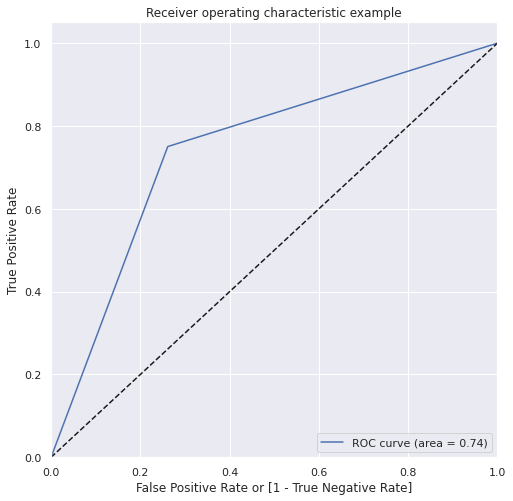

In [67]:
# Defining the function to plot the ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(8, 8))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    #plt.axvline(0.1, c='black', ls='dashed')
    plt.show()
    

    return None

# Calling the function
draw_roc(y_train_ada_pred_final.is_fraud, y_train_ada_pred_final.Predicted)

In [68]:
# Creating columns with different probability cutoffs

numbers = [float(x)/10 for x in range(10)]

for i in numbers:
    y_train_ada_pred_final[i] = y_train_ada_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
    
y_train_ada_pred_final.head()

,is_fraud,Conversion_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.829336,1,1,1,1,1,1,1,1,1,1,0
1,0,0.128885,0,1,1,0,0,0,0,0,0,0,0
2,0,0.264171,0,1,1,1,0,0,0,0,0,0,0
3,0,0.245248,0,1,1,1,0,0,0,0,0,0,0
4,0,0.028835,0,1,0,0,0,0,0,0,0,0,0


In [69]:
# Calculating accuracy, Precision & recall for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['probability','accuracy','precision','recall'])

num = [0.0,0.1,0.2,0.3,0.40,0.5,0.6,0.7,0.8,0.9]

for i in num:
    cm = metrics.confusion_matrix(y_train_ada_pred_final.is_fraud, y_train_ada_pred_final[i] )
    total = sum(sum(cm))
    
    accuracy = (cm[0,0] + cm[1,1]) / total    
    precision = cm[1,1] / (cm[1,1] + cm[0,1])
    recall = cm[1,1] / (cm[1,0] + cm[1,1])
    
    cutoff_df.loc[i] = [i, accuracy, precision, recall]
print(cutoff_df)

     probability  accuracy  precision    recall
0.0          0.0  0.499799   0.499799  1.000000
0.1          0.1  0.626980   0.573851  0.985516
0.2          0.2  0.712925   0.643850  0.952503
0.3          0.3  0.766074   0.700813  0.928236
0.4          0.4  0.772986   0.727499  0.872668
0.5          0.5  0.744442   0.741480  0.750258
0.6          0.6  0.722464   0.771067  0.632497
0.7          0.7  0.728333   0.829060  0.575005
0.8          0.8  0.748539   0.937322  0.532484
0.9          0.9  0.601266   0.981112  0.206181


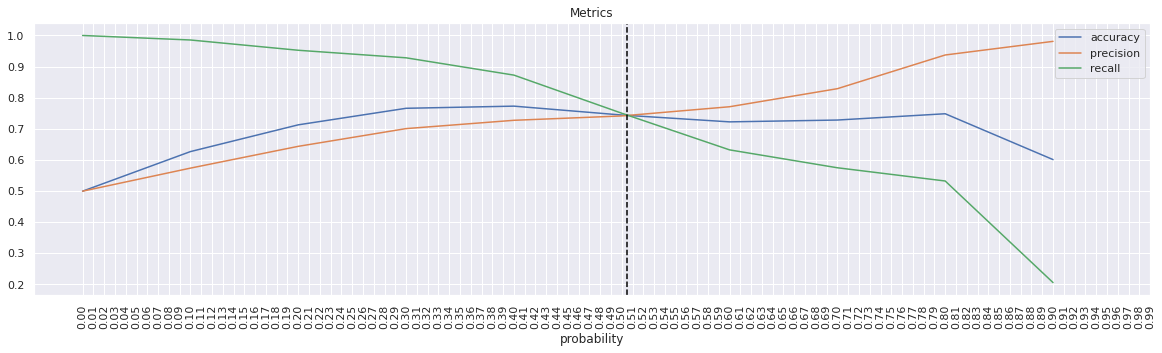

In [70]:
# Plot 'accuracy', 'Precision', 'recall' for various thresholds
cutoff_df.plot(x='probability', y=['accuracy', 'precision', 'recall'], figsize=(20,5), title='Metrics')
plt.axvline(0.505, c='black', ls='dashed')
plt.xticks(np.arange(0,1,step=0.01), rotation=90);

**Comments:**

> The best cut off is where accuracy, precision and recall intersect each other.

>In this case study our goal to correctly predict the yes cases.

>We need to focus on high recall & hence decreasing the threshold value from 0.505 to 0.3 as at 0.3 probability we get a recall value 0f 90%

In [71]:
#Revised cut - off - 0.3
# Adding final prediction based on new cut-off
y_train_ada_pred_final['Final_Predicted'] = y_train_ada_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.3  else 0)

y_train_ada_pred_final.head()

,is_fraud,Conversion_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Final_Predicted
0,0,0.829336,1,1,1,1,1,1,1,1,1,1,0,1
1,0,0.128885,0,1,1,0,0,0,0,0,0,0,0,0
2,0,0.264171,0,1,1,1,0,0,0,0,0,0,0,0
3,0,0.245248,0,1,1,1,0,0,0,0,0,0,0,0
4,0,0.028835,0,1,0,0,0,0,0,0,0,0,0,0


In [72]:
# Checking the metrics

print('AUC- ROC score on train set: ', (roc_auc_score(y_train_ada_pred_final.is_fraud, y_train_ada_pred_final.Final_Predicted))*100)
print('Recall on train set: ', (recall_score(y_train_ada_pred_final.is_fraud, y_train_ada_pred_final.Final_Predicted))*100)
print('Precision score on train set: ', (precision_score(y_train_ada_pred_final.is_fraud, y_train_ada_pred_final.Final_Predicted))*100)

AUC- ROC score on train set:  76.61390571102554
Recall on train set:  92.82363100452096
Precision score on train set:  70.08134062661455


##### Test set Evaluation

In [73]:
# Adding constant
X_test_sm = sm.add_constant(X_test[cols])

# Making predictions on test set
y_test_pred = log_model.predict(X_test_sm)

# Creating a data frame
y_test_pred_final = pd.DataFrame({'is_fraud':y_test.values, 'Converted_Prob':y_test_pred})

# Creating new column 'predicted' with 1 if Converted_Prob > 0.3 then 1  else 0
y_test_pred_final['Predicted'] = y_test_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.3 else 0)
y_test_pred_final.head()

,is_fraud,Converted_Prob,Predicted
83721,0,0.109265,0
122593,0,0.365480,1
996428,0,0.026215,0
589420,0,0.148282,0
1257845,0,0.772301,1


In [74]:
# Checking the metrics

print('AUC- ROC score on train set: ', (roc_auc_score(y_test_pred_final.is_fraud, y_test_pred_final.Predicted))*100)
print('Recall on train set: ', (recall_score(y_test_pred_final.is_fraud, y_test_pred_final.Predicted))*100)
print('Precision score on train set: ', (precision_score(y_test_pred_final.is_fraud, y_test_pred_final.Predicted))*100)

AUC- ROC score on train set:  77.66207561879106
Recall on train set:  94.88773747841105
Precision score on train set:  1.2403821840118483


### Logistic regression with weight of class balancing Technique

In [75]:
# Instantiate Logistic Regression with balancing techniques as weight og class
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train[cols], y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
#Prediction on the train set
y_train_pred = log_reg.predict(X_train[cols])

#Prediction on test set
y_test_pred = log_reg.predict(X_test[cols])

In [77]:
# Checking the metrics on train set
print('Performance for Train set')
print('AUC- ROC score ', (roc_auc_score(y_train,y_train_pred))*100)
print('Recall ', (recall_score(y_train,y_train_pred))*100)
print('Precision: ', (precision_score(y_train,y_train_pred))*100)
print("-"*50)

# Checking the metrics on test set
print('Performance for Test set')
print('AUC- ROC score', (roc_auc_score(y_test,y_test_pred))*100)
print('Recall: ', (recall_score(y_test,y_test_pred))*100)
print('Precision: ', (precision_score(y_test,y_test_pred))*100)

Performance for Train set
AUC- ROC score  78.06291720463918
Recall  75.93250444049734
Precision:  1.9683830864860716
--------------------------------------------------
Performance for Test set
AUC- ROC score 77.59777618636764
Recall:  74.99136442141624
Precision:  1.945218489879667


Linear model conclusion

| Model | AUC - ROC on Train set |Recall on train set|  AUC - ROC on test set |Recall on test set| 
| --- | --- |--- |--- |--- |
Linear model with ADASYN balancing technique|76.63|92.86|77.74|95.02|
Linear model with class weight balancing technique|78.11|76.06|77.02|75.09|

**Comment**

> Linear model with class weight balancing technquie has still not been tweaked for the best probability

> Balancing the data frame by using class weight technique gives far more better rersults than balancing the data set using ADASYN technquie.

> Going ahead, will only be using class weight balancing technique.

## Decision Trees

### Default Decision Tree

In [78]:
# Initiantiating an object : Using default parameters except for max depth)
dt = DecisionTreeClassifier(class_weight='balanced',random_state=100,max_depth=3)

# Fitting the same object
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

In [79]:
#Creating a function to plot the graph
def get_dt_graph(classifier):
    dot_data = StringIO()  

    export_graphviz(classifier, out_file=dot_data, filled=True, rounded=True,
                feature_names=X.columns, 
                class_names=['No Fraud', "Fraud"])

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

In [80]:
# Creating a function to test the train and test set model performance
def evaluate_model(classifier):
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)
    print('Performance for Train set')
    print('AUC- ROC score ', roc_auc_score(y_train,y_train_pred))
    print('Recall', recall_score(y_train,y_train_pred))
    print('Precision', precision_score(y_train,y_train_pred))   
    print("-"*50)
    print('Performance for Test set')
    print('AUC- ROC score ', roc_auc_score(y_test,y_test_pred))
    print('Recall', recall_score(y_test,y_test_pred))
    print('Precision', precision_score(y_test,y_test_pred))

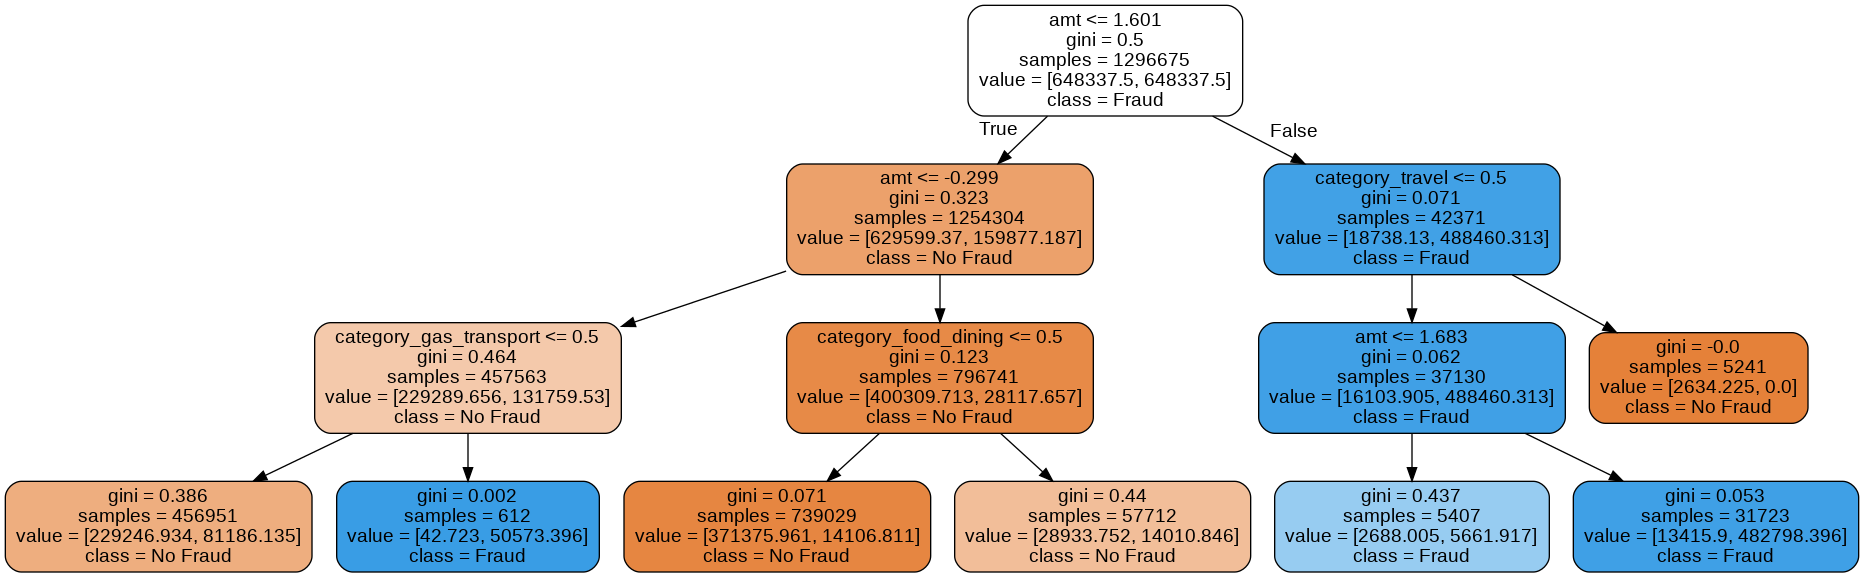

In [81]:
# Visualizing the model
grph = get_dt_graph(dt)
Image(grph.create_png())

In [82]:
#Evaluating the model
evaluate_model(dt)

Performance for Train set
AUC- ROC score  0.9032522266323696
Recall 0.831409117821196
Precision 0.1488262413226644
--------------------------------------------------
Performance for Test set
AUC- ROC score  0.9052356433365457
Recall 0.834887737478411
Precision 0.15186930568645932


### Hyper Parameter tuning - (Decision Trees)

In [83]:
# Instantiating Startified K - fold
cross_val = StratifiedKFold(n_splits=4, random_state=100)

# Instatiating Decision Tree
dtc = DecisionTreeClassifier()

#Defining paramters for random search
params = {
    'max_depth' : [10,20,30],
    'min_samples_split' :[10,30,50,70],
    'min_samples_leaf' :[10,30,50,70,100],
    'criterion' : ['gini'],
    'class_weight' : ['balanced']
}


In [84]:
# Instantiating randomised search CV with parameters defined above
random_search = RandomizedSearchCV(estimator=dtc, param_distributions=params, cv = cross_val, random_state=100,verbose=True)

#Fitting randomised search CV on X and Y trains
random_search.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  9.5min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=100, shuffle=False),
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
   

In [85]:
# Looking at the best estimators selected by random search
random_search.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [86]:
# Evaluating the model
dt_best = random_search.best_estimator_
evaluate_model(dt_best)

Performance for Train set
AUC- ROC score  0.993565875066574
Recall 1.0
Precision 0.2892742453436095
--------------------------------------------------
Performance for Test set
AUC- ROC score  0.9379634158286457
Recall 0.8894645941278065
Precision 0.2559896610000994


In [87]:
# importance of variables

imp_df = pd.DataFrame({
 'Variable' : X_train.columns,
    'Imp' : dt_best.feature_importances_
})

imp_df.sort_values(by = 'Imp', ascending = False)
imp_df

,Variable,Imp
0,amt,0.744984
1,gender,0.005681
2,lat,0.008166
3,long,0.007058
4,merch_lat,0.009698
5,merch_long,0.006169
6,category_food_dining,0.013815
7,category_gas_transport,0.074991
8,category_grocery,0.028629
9,category_health_fitness,0.003986


**Comment:**
> A four split stratified K fold was applied. 

> After hyper - parameter tuning, the performance of the model has improved drastically,

> Amount of transactions followed by lattidue & longitutdes are important features which help on determining whether the transaction will be a fraud or no.

## Random Forests

### Default Random Forests

In [88]:
# Building a default random forest model
#instantitating Random Forest classifier
rf = RandomForestClassifier(random_state=100,max_depth=3, n_estimators=10, class_weight='balanced', oob_score=True)

#Fitting the classifier on X & Y trains
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=True, random_state=100, verbose=0,
                       warm_start=False)

In [89]:
# Checking the different Decision Trees created by Random Forests
rf.estimators_

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=3, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=186422792, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=3, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=735107864, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=3, max_feature

In [90]:
# Checking OOB score of Random Forests
rf.oob_score_

0.8683239824936858

In [91]:
# Evaluating the model
evaluate_model(rf)

Performance for Train set
AUC- ROC score  0.8623068957224802
Recall 0.7482238010657194
Precision 0.1423542664038299
--------------------------------------------------
Performance for Test set
AUC- ROC score  0.860227678954474
Recall 0.7436960276338515
Precision 0.14352376508232784


### Hyper Parameter tuning - (Random Forests)

#### Search 1



In [92]:
# Instantiating cross validating object
cross_val = StratifiedKFold(n_splits=3, random_state=100)

# Instantiating the object
classifer_rf1 = RandomForestClassifier(random_state=100, n_jobs=-1, verbose=1)

#Setting the parameters
params = {
    'max_depth' : [30,50],
    'min_samples_split' :[30,75],
    'min_samples_leaf' : [30,80],
    'max_features' : [5,10],
    'n_estimators' :[10,50],
    'class_weight':['balanced'],
    'oob_score' : ['True']
}

In [93]:
# # Instantiating the random search with above parameters
# random_search1 = RandomizedSearchCV(estimator=classifer_rf1, param_distributions=params, verbose=1, n_jobs= -1,cv=cross_val,n_iter=10)

# # Fitting random search on X & Y trains
# random_search1.fit(X_train, y_train)



In [94]:
# # Storing results of best estimator
# search1_results = random_search1.best_estimator_
# search1_results

**NOTE:**
> The above code took 30 mins to run

> It was not possible to run this code everytime and wait for the results.

> Hence stored the results of the randomgrid search in variable search1_best_params

>In case, you want to run the code **REMOVE THE COMMENTS** from above two block of codes **& comment the below two blocks of code**

In [95]:
# The best estimator results is stored in a dictionary
search1_best_params = {
    'max_depth' : [30],
    'min_samples_split' :[75],
    'min_samples_leaf' : [30],
    'max_features' : [5],
    'n_estimators' :[50],
    'class_weight':['balanced'],
    'oob_score' : ['True']
}

In [96]:
# Instantiating the random search 
search1_results = RandomizedSearchCV(estimator=classifer_rf1, param_distributions=search1_best_params, verbose=1, n_jobs= -1,cv=cross_val,n_iter=10)

# Fitting the random search on X & Y trains
search1_results.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=False),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_spl...
                     

In [97]:
# Evaluating the model
evaluate_model(search1_results)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.8s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    7.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    3.2s finished


Performance for Train set
AUC- ROC score  0.9938894159045994
Recall 0.9943753700414446
Precision 0.4411899914625337
--------------------------------------------------
Performance for Test set
AUC- ROC score  0.930147833249943
Recall 0.8670120898100173
Precision 0.4033424393379399


#### Search 2

Trying another set of parameters 

In [98]:
# Instantiating cross validating object
cross_val = StratifiedKFold(n_splits=3, random_state=100)

# Instantiating random forest object
classifer_rf2 = RandomForestClassifier(random_state=100, n_jobs=-1, verbose=1)

#Setting the parameters
params = {
    'max_depth' : [75,100],
    'min_samples_split' :[50,100],
    'min_samples_leaf' : [50,100],
    'max_features' : [4,6],
    'n_estimators' :[100,200],
    'class_weight':['balanced'],
    'oob_score' : ['True']
}

In [99]:
# # Instantiating the random search 
# random_search2 = RandomizedSearchCV(estimator=classifer_rf2, param_distributions=params, verbose=1, n_jobs= -1,cv=cross_val,n_iter=10)

# # Fitting the random search object on X & Y trains
# random_search2.fit(X_train, y_train)

In [100]:
# # Storing results of best estimator
# search2_results = random_search2.best_estimator_
# search2_results

**NOTE:**
>The above code took 2 hours to run

>It was not possible to run this code everytime and wait for the results.

>Hence stored the best estimator results of the randomgrid search in variable search2_best_params

>In case, you want to run the code **REMOVE THE COMMENTS** from above **two block of codes & comment the below two blocks of code**

In [101]:
# The best estimator results is stored in a dictionary
search2_best_params= {
    'max_depth' : [100],
    'min_samples_split' :[100],
    'min_samples_leaf' : [50],
    'max_features' : [4],
    'n_estimators' :[100],
    'class_weight':['balanced'],
    'oob_score' : ['True']
    }

In [102]:
# Instantiating the search 
search2_results = RandomizedSearchCV(estimator=classifer_rf2, param_distributions=search2_best_params, verbose=1, n_jobs= -1,cv=cross_val,n_iter=10)

# Fitting random search object on X & Y trains
search2_results.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=False),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_spl...
                     

In [103]:
# Evaluating the model
evaluate_model(search2_results)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   15.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    6.6s finished


Performance for Train set
AUC- ROC score  0.990458402693954
Recall 0.9890467732386027
Precision 0.3891898188595725
--------------------------------------------------
Performance for Test set
AUC- ROC score  0.929064381366885
Recall 0.8663212435233161
Precision 0.3564018757993463


#### Search 3

Again trying another set of parameters

In [104]:
# Instantiating cross validating object
cross_val = StratifiedKFold(n_splits=3, random_state=100)

# Instantiating random forest classifer object
classifer_rf3 = RandomForestClassifier(random_state=100, n_jobs=-1, verbose=1)

#Setting the parameters
params = {
    'max_depth' : [65],
    'min_samples_split' :[80,120],
    'min_samples_leaf' : [40],
    'max_features' : [4],
    'n_estimators' :[100],
    'class_weight':['balanced'],
    'oob_score' : ['True']
}

In [105]:
# # Instantiating the random search 
# random_search3 = RandomizedSearchCV(estimator=classifer_rf3, param_distributions=params, verbose=1, n_jobs= -1,cv=cross_val,n_iter=10)

# # Fitting the random search object on X & Y trains
# random_search3.fit(X_train, y_train)

In [106]:
# # Storing results of best estimator
# search3_results = random_search3.best_estimator_
# search3_results

**NOTE:**
> The above code took 5 hours to run

> It was not possible to run this code everytime and wait for the results.

> Hence stored the results of the randomgrid search in variable search3_best_params

>In case, you want to run the code **REMOVE THE COMMENTS** from above two block of codes **& comment the below two blocks of code**

In [107]:
# The best estimator results is stored in a dictionary
search3_best_params = {
    'max_depth' : [65],
    'min_samples_split' :[80],
    'min_samples_leaf' : [40],
    'max_features' : [4],
    'n_estimators' :[100],
    'class_weight':['balanced'],
    'oob_score' : ['True']
}


In [108]:
# Instantiating the search 
search3_results = RandomizedSearchCV(estimator=classifer_rf3, param_distributions=search3_best_params, verbose=1, n_jobs= -1,cv=cross_val,n_iter=10)

# Fitting above object on X & Y trains
search3_results.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=False),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_spl...
                     

In [109]:
# Evaluating the model
evaluate_model(search3_results)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   15.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    6.7s finished


Performance for Train set
AUC- ROC score  0.9925420400053016
Recall 0.9923031379514505
Precision 0.41858141858141856
--------------------------------------------------
Performance for Test set
AUC- ROC score  0.9262115693759139
Recall 0.8597582037996546
Precision 0.38034841075794623


#### Search 4

In [110]:
# Instantiating cross validating object
cross_val = StratifiedKFold(n_splits=3, random_state=100)

# Instantiating random forest classifer object
classifer_rf4 = RandomForestClassifier(random_state=100, n_jobs=-1, verbose=1)

#Setting the parameters
params = {
    'max_depth' : [60],
    'min_samples_split' :[40,60],
    'min_samples_leaf' : [40],
    'max_features' : [4],
    'n_estimators' :[200],
    'class_weight':['balanced'],
    'oob_score' : ['True']
}

In [111]:
# # Instantiating the random search 
# random_search4 = RandomizedSearchCV(estimator=classifer_rf4, param_distributions=params, verbose=1, n_jobs= -1,cv=cross_val,n_iter=10)

# # Fitting the random search object on X & Y trains
# random_search4.fit(X_train, y_train)

In [112]:
# # Storing results of best estimator
# search4_results = random_search4.best_estimator_
# search4_results

**NOTE:**

> The above code took 5 hours to run

> It was not possible to run this code everytime and wait for the results.

> Hence stored the results of the randomgrid search in variable search4_best_params

>In case, you want to run the code **REMOVE THE COMMENTS** from above two block of codes **& comment the below two blocks of code**

In [113]:
# The best estimator results is stored in a dictionary
search4_best_params = {
    'max_depth' : [60],
    'min_samples_split' :[40],
    'min_samples_leaf' : [40],
    'max_features' : [4],
    'n_estimators' :[200],
    'class_weight':['balanced'],
    'oob_score' : ['True']
}


In [114]:
# Instantiating the search 
search4_results = RandomizedSearchCV(estimator=classifer_rf4, param_distributions=search4_best_params, verbose=1, n_jobs= -1,cv=cross_val,n_iter=10)

# Fitting above object on X & Y trains
search4_results.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 12.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.8min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=False),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_spl...
                     

In [115]:
# Evaluating the model
evaluate_model(search4_results)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   31.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   31.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   14.8s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   15.0s finished


Performance for Train set
AUC- ROC score  0.9932580903778147
Recall 0.9937833037300178
Precision 0.4173296867230234
--------------------------------------------------
Performance for Test set
AUC- ROC score  0.9267441752426986
Recall 0.8607944732297064
Precision 0.3815648445873526


#### Search 5


Just trying random arbitary values

In [116]:
# Just trying out a random model 

# Instantiating cross validating object
cross_val = StratifiedKFold(n_splits=4, random_state=100)

# Instantiating random forest object
classifer_rf5 = RandomForestClassifier(random_state=100, n_jobs=-1, verbose=1)

#Setting the parameters
params = {
    'max_depth' : [40],
    'min_samples_split' :[30],
    'min_samples_leaf' : [40],
    'max_features' : [6],
    'n_estimators' :[200],
    'class_weight':['balanced'],
    'oob_score' : ['True']
}

In [ ]:
# Instantiating the random search with above parameters
random_search5 = RandomizedSearchCV(estimator=classifer_rf5, param_distributions=params, verbose=1, n_jobs= -1,cv=cross_val,n_iter=10)

# Fitting random search on X & Y trains
random_search5.fit(X_train, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
#Evaluating the model
evaluate_model(random_search5)

## Best model (Model Conclusions)

| Model | AUC - ROC on Train set |Recall on train set|  AUC - ROC on test set |Recall on test set| 
| --- | --- |--- |--- |--- |
**Linear model with ADASYN balancing technique**|76.63|92.86|77.74|95.02|
**Linear model with class weight balancing technique**|78.11|76.06|77.02|75.09|
**Decision tree - Default**| 90.3|83.1|90.5|83.4|
**Decision tree - Hyper parameter tuned**|99.3|100|93.7|88.9
**Random Forests - Default**|86.2|74.8|86.02|74.3|
**Random Forests - Hyper parameter tuned - Search 1**|99.3|99.4|93.01|86.7|
**Random Forests - Hyper parameter tuned - Search 2**|99.0|98.9|92.9|86.6|
**Random Forests - Hyper parameter tuned - Search 3**|99.7|99.9|92.6|85.7|
**Random Forests - Hyper parameter tuned - Search 4**|99.3|99.3|92.6|86.07|
**Random Forests - Hyper parameter tuned - Search 5**|99.4|99.6|93.8|88.5|


**Comments:**

> In this case of fraud detection, the best model would be the one which has high Recall score along with a good AUC - ROC score.

>From all of the models built so far, hyper parameter tuned Decision tree is having the highest recall on both the train and test sets as compared to other models. Also the ROC - AUC score is good enough.

> Will consider my best model - this hyper - parameterised Decision tree

# Excel Prep

Since the best model selected is Decision tree with hyper paramter tuning, will merge the train and test predictions from this tree into one data frame in order to perform Excel related operations smoothly!


In [ ]:
# Creating a new data frame that will hold the orignal fraud values & predicted fraud values from the train set
y_test_pred = dt_best.predict(X_test)
y_test_pred_final = pd.DataFrame({'is_fraud':y_test.values, 'Predicted':y_test_pred})
#y_test_pred_final['Index'] = y_test.index
y_test_pred_final.set_index(y_test.index, inplace=True)
y_test_pred_final.head()

In [ ]:
# Creating a new data frame that will hold the orignal fraud values & predicted fraud values from the test set
y_train_pred = dt_best.predict(X_train)
y_train_pred_final = pd.DataFrame({'is_fraud':y_train.values, 'Predicted':y_train_pred})
y_train_pred_final.set_index(y_train.index, inplace=True)
y_train_pred_final.head()


In [ ]:
# Merging the predicted train & test sets

y_pred = y_train_pred_final.append(y_test_pred_final)

#Checking the shape after merging
print('Master dataframe shape": ', y_pred.shape)

## Average transactions per month

In [ ]:
# Finding average number of transactions per month
round((len(master_df.index)/12),2)

## Average fraud transactions per month

In [ ]:
# Finding the average number of fraud transactions per month
round((master_df['is_fraud'].sum()/12),2)

## Average amount per fraud transaction

In [ ]:
# Fining avg amount of fraud transactions per month
round((master_df.loc[master_df['is_fraud']==1,'amt'].mean()),2)

## Average transactions detected fraudent my model per month

In [ ]:
# Finding the number of transactions detected fradulent by the model per month
round(((y_pred['Predicted'] ==1).sum()/12),2)

## Average number of transactions per month that are fraudulent but not detected by the model 

In [ ]:
# Transactions that are fraudent but not detected by the system.
print (metrics.confusion_matrix(y_true=y_pred['is_fraud'], y_pred=y_pred['Predicted']))